In [3]:
#HW 1
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from glob import glob
import re
import sys
import plotly.express as px
#from textparser import TextParser
import seaborn as sns
import numpy as np

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


## Box: https://virginia.app.box.com/folder/0

In [4]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current directory
print(current_directory)


/home/sagemaker-user


In [5]:
import glob

# Path to the directory containing the text files
directory_path = '/home/sagemaker-user/'

# Pattern to match all text files in the directory
files_pattern = f"{directory_path}*.txt"

# Using glob to get the list of file paths
file_paths = glob.glob(files_pattern)

# Reading and combining the contents of all files
combined_text = ""
for file_path in file_paths:
    with open(file_path, 'r', encoding='utf-8') as file:
        combined_text += file.read() + "\n"

# Print or save the combined text
print(combined_text)
# or save it to a file
with open(f"{directory_path}combined_text.txt", 'w', encoding='utf-8') as output_file:
    output_file.write(combined_text)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [6]:
text_file_1 = "the_accumulation_of_capital.txt"
text_file_2 = "The_Conquest_of_Bread.txt"
text_file_3 = "the_jungle.txt"
text_file_4 = "the_wealth_of_nations.txt"


In [7]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [8]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_1, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

In [13]:
#LINES.sample(20)

In [9]:

# New pattern to match the chapter headings in your book
chap_pat = r"^_CHAPTER\s+[IVXLCDM]+_$"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())


Lines matching chapter pattern: 31


In [10]:
if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

line_str  chap_num
line_num                                                             
9422      smaller share of the product. Rodbertus takes ...      15.0
1751      capital, and provisions for the remaining 1,00...       2.0
13876     absolutely and in relation to the surplus valu...      25.0
13698     Thus the increase in the variable capital is d...      25.0
3163      individual representations of fixed capital. I...       4.0
15532     The Commissioner of the State of New Hampshire...      28.0
14074     nature, economic organisation is essentially i...      26.0
11929     assumption, therefore, Tugan Baranovski descri...      22.0
1055                                            _CHAPTER I_       1.0
7898      Sismondi now takes constant capital into accou...      11.0

In [11]:
# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)

# Since we don't have book_id, sent_num, and token_num at this point, you would need to incorporate those in subsequent processing steps.
# Display the first few paragraphs
PARAS.head()

chap_num  para_num                                           para_str
0       1.0         0                                        _CHAPTER I_
1       1.0         1                    THE OBJECT OF OUR INVESTIGATION
2       1.0         2  Karl Marx made a contribution of lasting servi...
3       1.0         3  What is it precisely that constitutes this pro...
4       1.0         4  On the other hand, at all stages of social dev...

In [12]:
# Set up the OHCO index hierarchy
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

# Your dataframe 'LINES' should already be properly loaded and chapters identified

# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 1) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_1_DF = TOKENS
BOOK_1_DF.head(40)

token_str       term_str
book_id chap_num para_num sent_num token_num                              
1       1.0      0        0        0               _CHAPTER        chapter
                                   1                     I_              i
                 1        0        0                    THE            the
                                   1                 OBJECT         object
                                   2                     OF             of
                                   3                    OUR            our
                                   4          INVESTIGATION  investigation
                 2        0        0                   Karl           karl
                                   1                   Marx           marx
                                   2                   made           made
                                   3                      a              a
                                   4           contribution   contribution
                                   5                     of             of
                                   6                lasting        lasting
                                   7                service        service
                                   8                     to             to
                                   9                    the            the
                                   10                theory         theory
                                   11                    of             of
                                   12             economics      economics
                                   13                  when           when
                                   14                    he             he
                                   15                  drew           drew
                                   16             attention      attention
                                   17                    to             to
                                   18                   the            the
                                   19               problem        problem
                                   20                    of             of
                                   21                   the            the
                                   22          reproduction   reproduction
                                   23                    of             of
                                   24                   the            the
                                   25                entire         entire
                                   26                social         social
                                   27              capital.        capital
                          1        0                     It             it
                                   1                     is             is
                                   2            significant    significant
                                   3                   that           that
                                   4                     in             in

In [13]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_2, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^CHAPTER\s+[IVXLCDM]+\s*$"

chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 2) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_2_DF = TOKENS
BOOK_2_DF.head(40)

Lines matching chapter pattern: 17


token_str    term_str
book_id chap_num para_num sent_num token_num                        
2       1.0      0        0        0             CHAPTER     chapter
                                   1                   I           i
                 1        0        0                 OUR         our
                                   1              RICHES      riches
                 2        0        0                   I           i
                 3        0        0                 The         the
                                   1               human       human
                                   2                race        race
                                   3                 has         has
                                   4           travelled   travelled
                                   5                   a           a
                                   6                long        long
                                   7                 way         way
                                   8               since       since
                                   9               those       those
                                   10             remote      remote
                                   11               ages        ages
                                   12               when        when
                                   13                men         men
                                   14          fashioned   fashioned
                                   15              their       their
                                   16               rude        rude
                                   17         implements  implements
                                   18                 of          of
                                   19              flint       flint
                                   20                and         and
                                   21              lived       lived
                                   22                 on          on
                                   23                the         the
                                   24         precarious  precarious
                                   25             spoils      spoils
                                   26                 of          of
                                   27            hunting     hunting
                                   28            leaving     leaving
                                   29                 to          to
                                   30              their       their
                                   31           children    children
                                   32                for         for
                                   33              their       their
                                   34               only        only

In [14]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_3, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

# Improved regex to avoid table of contents chapters
chap_pat = r"^CHAPTER\s+[IVXLCDM]+\s*$"

# Exclude the table of contents lines
lines_without_toc = LINES.loc[~LINES.index.isin(range(37, 75))]

# Apply the chapter pattern only on the filtered lines
chap_lines = lines_without_toc.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    lines_without_toc['chap_num'] = None
    lines_without_toc.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    lines_without_toc['chap_num'] = lines_without_toc['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Merge the chapter numbers back into the original DataFrame
LINES['chap_num'] = lines_without_toc['chap_num']

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)

# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 3) # Assuming 3 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_3_DF = TOKENS
BOOK_3_DF.head(40)


Lines matching chapter pattern: 31


/tmp/ipykernel_4037/144686300.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_without_toc['chap_num'] = None
/tmp/ipykernel_4037/144686300.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_without_toc['chap_num'] = lines_without_toc['chap_num'].ffill()


token_str     term_str
book_id chap_num para_num sent_num token_num                           
3       1.0      0        0        0               CHAPTER      chapter
                                   1                     I            i
                 1        0        0                    It           it
                                   1                   was          was
                                   2                  four         four
                                   3             oâclock      oâclock
                                   4                  when         when
                                   5                   the          the
                                   6              ceremony     ceremony
                                   7                   was          was
                                   8                  over         over
                                   9                   and          and
                                   10                  the          the
                                   11            carriages    carriages
                                   12                began        began
                                   13                   to           to
                                   14              arrive.       arrive
                          1        0                 There        there
                                   1                   had          had
                                   2                  been         been
                                   3                     a            a
                                   4                 crowd        crowd
                                   5             following    following
                                   6                   all          all
                                   7                   the          the
                                   8                   way          way
                                   9                 owing        owing
                                   10                   to           to
                                   11                  the          the
                                   12           exuberance   exuberance
                                   13                   of           of
                                   14               Marija       marija
                                   15         Berczynskas.  berczynskas
                          2        0                   The          the
                                   1              occasion     occasion
                                   2                rested       rested
                                   3               heavily      heavily
                                   4                  upon         upon
                                   5            Marijaâs     marijaâs
                                   6                 broad        broad

In [15]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_4, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 4) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_4_DF = TOKENS
BOOK_4_DF.head(40)

Lines matching chapter pattern: 65


token_str   term_str
book_id chap_num para_num sent_num token_num                      
4       1.0      0        0        0            CHAPTER    chapter
                                   1                 I.          i
                          1        0                 OF         of
                                   1                THE        the
                                   2           DIVISION   division
                                   3                 OF         of
                                   4            LABOUR.     labour
        2.0      0        0        0            CHAPTER    chapter
                                   1                II.         ii
                          1        0                 OF         of
                                   1                THE        the
                                   2          PRINCIPLE  principle
                                   3              WHICH      which
                                   4              GIVES      gives
                                   5           OCCASION   occasion
                                   6                 TO         to
                                   7                THE        the
                                   8           DIVISION   division
                                   9                 OF         of
                                   10           LABOUR.     labour
        3.0      0        0        0            CHAPTER    chapter
                                   1               III.        iii
                          1        0               THAT       that
                                   1                THE        the
                                   2           DIVISION   division
                                   3                 OF         of
                                   4             LABOUR     labour
                                   5                 IS         is
                                   6            LIMITED    limited
                                   7                 BY         by
                                   8                THE        the
                                   9             EXTENT     extent
                                   10                OF         of
                                   11               THE        the
                                   12           MARKET.     market
        4.0      0        0        0            CHAPTER    chapter
                                   1                IV.         iv
                          1        0                 OF         of
                                   1                THE        the
                                   2             ORIGIN     origin

In [31]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_4, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

# Skip the lines containing the table of contents (lines 36 to 107)
lines_without_toc = LINES.loc[~LINES.index.isin(range(36, 108))]

# Chapter pattern
chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = lines_without_toc.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    lines_without_toc['chap_num'] = None
    lines_without_toc.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Forward fill chapter numbers
    lines_without_toc['chap_num'] = lines_without_toc['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Merge the chapter numbers back into the original DataFrame
LINES['chap_num'] = lines_without_toc['chap_num']

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)

# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 4) # Assuming 4 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_4_DF = TOKENS
BOOK_4_DF.head(40)


Lines matching chapter pattern: 33


/tmp/ipykernel_108/342997891.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_without_toc['chap_num'] = None
/tmp/ipykernel_108/342997891.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lines_without_toc['chap_num'] = lines_without_toc['chap_num'].ffill()


token_str      term_str
book_id chap_num para_num sent_num token_num                            
4       1.0      0        0        0               CHAPTER       chapter
                                   1                    I.             i
                          1        0                    OF            of
                                   1                   THE           the
                                   2              DIVISION      division
                                   3                    OF            of
                                   4               LABOUR.        labour
                 1        0        0                   The           the
                                   1              greatest      greatest
                                   2          improvements  improvements
                                   3                    in            in
                                   4                   the           the
                                   5            productive    productive
                                   6                powers        powers
                                   7                    of            of
                                   8                labour        labour
                                   9                   and           and
                                   10                  the           the
                                   11              greater       greater
                                   12                 part          part
                                   13                   of            of
                                   14                  the           the
                                   15                skill         skill
                                   16            dexterity     dexterity
                                   17                  and           and
                                   18             judgment      judgment
                                   19                 with          with
                                   20                which         which
                                   21                   it            it
                                   22                   is            is
                                   23             anywhere      anywhere
                                   24             directed      directed
                                   25                   or            or
                                   26              applied       applied
                                   27                 seem          seem
                                   28                   to            to
                                   29                 have          have
                                   30                 been          been
                                   31                  the           the
                                   32              effects       effects

In [34]:
print(BOOK_1_DF.head())
print(BOOK_2_DF.head())
print(BOOK_3_DF.head())
print(BOOK_4_DF.head())

                                             token_str term_str
book_id chap_num para_num sent_num token_num                   
1       1.0      0        0        0          _CHAPTER  chapter
                                   1                I_        i
                 1        0        0               THE      the
                                   1            OBJECT   object
                                   2                OF       of
                                             token_str term_str
book_id chap_num para_num sent_num token_num                   
2       1.0      0        0        0           CHAPTER  chapter
                                   1                 I        i
                 1        0        0               OUR      our
                                   1            RICHES   riches
                 2        0        0                 I        i
                                             token_str term_str
book_id chap_num para_num sent_num token

In [35]:
CORPUS = pd.concat([BOOK_1_DF, BOOK_2_DF, BOOK_3_DF, BOOK_4_DF])
print(CORPUS)

                                             token_str term_str
book_id chap_num para_num sent_num token_num                   
1       1.0      0        0        0          _CHAPTER  chapter
                                   1                I_        i
                 1        0        0               THE      the
                                   1            OBJECT   object
                                   2                OF       of
...                                                ...      ...
4       33.0     147      0        34               to       to
                                   35             hear     hear
                                   36            about    about
                                   37              new      new
                                   38          eBooks.   ebooks

[785865 rows x 2 columns]


In [36]:
import nltk
from nltk import pos_tag
import pandas as pd

# Load required NLTK resources
nltk.download('averaged_perceptron_tagger')

# Define a mapping for POS groups based on NLTK's documentation


# Function to get POS and POS group
def get_pos_and_group(word):
    tag = pos_tag([word])[0][1]  # Tag the word, pos_tag returns a list of tuples (word, tag)
    return tag

# Apply the function to the 'token_str' column of CORPUS DataFrame
CORPUS['pos'] = CORPUS['token_str'].apply(get_pos_and_group)
CORPUS['pos_group'] = CORPUS.pos.str[:2]

# Display the DataFrame to verify
CORPUS

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sagemaker-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


token_str term_str pos pos_group
book_id chap_num para_num sent_num token_num                                 
1       1.0      0        0        0          _CHAPTER  chapter  NN        NN
                                   1                I_        i  NN        NN
                 1        0        0               THE      the  DT        DT
                                   1            OBJECT   object  NN        NN
                                   2                OF       of  IN        IN
...                                                ...      ...  ..       ...
4       33.0     147      0        34               to       to  TO        TO
                                   35             hear     hear  NN        NN
                                   36            about    about  IN        IN
                                   37              new      new  JJ        JJ
                                   38          eBooks.   ebooks  NN        NN

[785865 rows x 4 columns]

In [57]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Load required NLTK resources
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Define a mapping for POS groups based on NLTK's documentation
def get_pos_and_group(word):
    tag = nltk.pos_tag([word])[0][1]
    return tag, tag[:2]

# Load stopwords and initialize stemmer
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# Apply POS tagging and grouping to the 'token_str' column of CORPUS DataFrame
CORPUS['pos'], CORPUS['pos_group'] = zip(*CORPUS['token_str'].apply(get_pos_and_group))

# Filter out empty term strings
CORPUS = CORPUS[CORPUS['term_str'] != '']

# Create the VOCAB DataFrame with basic counts
VOCAB = CORPUS['term_str'].value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB['n'] / VOCAB['n'].sum()
VOCAB['i'] = -np.log2(VOCAB['p'])

# Calculate the most frequent POS and POS group
max_pos = CORPUS.groupby('term_str')['pos'].agg(lambda x: x.mode()[0])
max_pos_group = CORPUS.groupby('term_str')['pos_group'].agg(lambda x: x.mode()[0])
VOCAB = VOCAB.join(max_pos.rename('max_pos'))
VOCAB = VOCAB.join(max_pos_group.rename('max_pos_group'))

# Add stemming and stop word flag
VOCAB['porter_stem'] = VOCAB.index.map(porter.stem)
VOCAB['stop'] = VOCAB.index.map(lambda x: 1 if x in stop_words else 0)

# Display the head of the VOCAB table to verify
VOCAB


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sagemaker-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


n         p          i max_pos max_pos_group porter_stem  stop
term_str                                                                   
0          432  0.000551  10.826786      CD            CD           0     0
000        410  0.000523  10.902193      CD            CD         000     0
000397       1  0.000001  19.581673      CD            CD      000397     0
000412       1  0.000001  19.581673      CD            CD      000412     0
000c        27  0.000034  14.826786      CD            CD        000c     0
...        ...       ...        ...     ...           ...         ...   ...
ãlites       1  0.000001  19.581673      NN            NN       ãlite     0
ãlãgantes    1  0.000001  19.581673      NN            NN     ãlãgant     0
ãtat         1  0.000001  19.581673      NN            NN        ãtat     0
ãªtre        2  0.000003  18.581673      NN            NN       ãªtre     0
ã¼ber        8  0.000010  16.581673      NN            NN       ã¼ber     0

[25234 rows x 7 columns]

In [61]:
TFIDF, DFIDF = get_tfidf(BOW)

# Merge DFIDF values into the VOCAB DataFrame
VOCAB['dfidf'] = DFIDF
VOCAB

n         p          i max_pos max_pos_group porter_stem  stop  \
term_str                                                                      
0          432  0.000551  10.826786      CD            CD           0     0   
000        410  0.000523  10.902193      CD            CD         000     0   
000397       1  0.000001  19.581673      CD            CD      000397     0   
000412       1  0.000001  19.581673      CD            CD      000412     0   
000c        27  0.000034  14.826786      CD            CD        000c     0   
...        ...       ...        ...     ...           ...         ...   ...   
ãlites       1  0.000001  19.581673      NN            NN       ãlite     0   
ãlãgantes    1  0.000001  19.581673      NN            NN     ãlãgant     0   
ãtat         1  0.000001  19.581673      NN            NN        ãtat     0   
ãªtre        2  0.000003  18.581673      NN            NN       ãªtre     0   
ã¼ber        8  0.000010  16.581673      NN            NN       ã¼ber     0   

               dfidf  
term_str              
0          25.334355  
000        59.441920  
000397      6.807355  
000412      6.807355  
000c       25.334355  
...              ...  
ãlites      6.807355  
ãlãgantes   6.807355  
ãtat        6.807355  
ãªtre      11.614710  
ã¼ber      28.000000  

[25234 rows x 8 columns]

## DFIDF, TFIDF BOW and VOCAB

In [50]:
bag = ['book_id', 'chap_num']  # Adjust according to your data structure

# Create the BOW
BOW = create_bow(CORPUS, bag=bag)

# Optionally compute TF-IDF
TFIDF, _ = get_tfidf(BOW)
BOW['tfidf'] = TFIDF.stack()

# Display the first few rows of the BOW DataFrame
BOW

n     tfidf
book_id chap_num term_str                  
1       1.0                    13  0.027420
                 000            2  0.006276
                 100            1  0.005227
                 10s            1  0.008658
                 10vâ           1  0.014735
...                            ..       ...
4       33.0     âinformation   1  0.002841
                 âplain         2  0.005302
                 âproject       5  0.014206
                 âright         1  0.002841
                 âthe           1  0.001559

[150734 rows x 2 columns]

In [62]:
VOCAB

n         p          i max_pos max_pos_group porter_stem  stop  \
term_str                                                                      
0          432  0.000551  10.826786      CD            CD           0     0   
000        410  0.000523  10.902193      CD            CD         000     0   
000397       1  0.000001  19.581673      CD            CD      000397     0   
000412       1  0.000001  19.581673      CD            CD      000412     0   
000c        27  0.000034  14.826786      CD            CD        000c     0   
...        ...       ...        ...     ...           ...         ...   ...   
ãlites       1  0.000001  19.581673      NN            NN       ãlite     0   
ãlãgantes    1  0.000001  19.581673      NN            NN     ãlãgant     0   
ãtat         1  0.000001  19.581673      NN            NN        ãtat     0   
ãªtre        2  0.000003  18.581673      NN            NN       ãªtre     0   
ã¼ber        8  0.000010  16.581673      NN            NN       ã¼ber     0   

               dfidf  
term_str              
0          25.334355  
000        59.441920  
000397      6.807355  
000412      6.807355  
000c       25.334355  
...              ...  
ãlites      6.807355  
ãlãgantes   6.807355  
ãtat        6.807355  
ãªtre      11.614710  
ã¼ber      28.000000  

[25234 rows x 8 columns]

In [64]:
VOCAB_sorted = VOCAB.sort_values(by='dfidf', ascending=False)

top_20_significant = VOCAB_sorted.head(20)

top_20_significant

n         p          i max_pos max_pos_group porter_stem  stop  \
term_str                                                                        
loss         127  0.000162  12.592989      NN            NN        loss     0   
machinery    143  0.000182  12.421802      NN            NN   machineri     0   
constant     279  0.000356  11.457552      JJ            JJ    constant     0   
hour         131  0.000167  12.548250      NN            NN        hour     0   
town         159  0.000203  12.268790      NN            NN        town     0   
sight         71  0.000090  13.431926      NN            NN       sight     0   
understood    74  0.000094  13.372220      NN            NN  understood     0   
act          147  0.000187  12.382001      NN            NN         act     0   
maintenance  168  0.000214  12.189356      NN            NN     mainten     0   
forms        106  0.000135  12.853753     NNS            NN        form     0   
drawn        113  0.000144  12.761494      NN            NN       drawn     0   
experience    83  0.000106  13.206634      NN            NN      experi     0   
increasing   187  0.000238  12.034779     VBG            VB     increas     0   
ordinary     280  0.000357  11.452390      JJ            JJ    ordinari     0   
ancient      256  0.000326  11.581673      NN            NN     ancient     0   
000          410  0.000523  10.902193      CD            CD         000     0   
iron          83  0.000106  13.206634      NN            NN        iron     0   
likely       223  0.000284  11.780773      JJ            JJ        like     0   
likewise     140  0.000178  12.452390      RB            RB     likewis     0   
secondly     133  0.000170  12.526391      RB            RB    secondli     0   

                dfidf  
term_str               
loss         59.44192  
machinery    59.44192  
constant     59.44192  
hour         59.44192  
town         59.44192  
sight        59.44192  
understood   59.44192  
act          59.44192  
maintenance  59.44192  
forms        59.44192  
drawn        59.44192  
experience   59.44192  
increasing   59.44192  
ordinary     59.44192  
ancient      59.44192  
000          59.44192  
iron         59.44192  
likely       59.44192  
likewise     59.44192  
secondly     59.44192

## LIB

In [38]:
import pandas as pd

# Book data
data = {
    'title': [
        'The Accumulation of Capital', 
        'The Conquest of Bread',
        'The Jungle',
        'The Wealth of Nations'
    ],
    'author': [
        'Rosa Luxemburg', 
        'Peter Kropotkin', 
        'Upton Sinclair', 
        'Adam Smith'
    ],
    'year_of_publish': [
        '1913',           # The Accumulation of Capital
        '1892',           # The Conquest of Bread
        '1906',           # The Jungle
        '1776'            # The Wealth of Nations
    ],
    'book_id': [1, 2, 3, 4]
}

# Create the DataFrame
LIB = pd.DataFrame(data).set_index('book_id')

# Display the DataFrame
LIB


title           author year_of_publish
book_id                                                              
1        The Accumulation of Capital   Rosa Luxemburg            1913
2              The Conquest of Bread  Peter Kropotkin            1892
3                         The Jungle   Upton Sinclair            1906
4              The Wealth of Nations       Adam Smith            1776

In [81]:
import os

# Define the file paths
file_paths = [
    "the_accumulation_of_capital.txt",
    "The_Conquest_of_Bread.txt",
    "the_jungle.txt",
    "the_wealth_of_nations.txt"
]

# Calculate the size of each file in bytes and convert it to characters
file_sizes = [os.path.getsize(file_path) for file_path in file_paths]
file_sizes_in_characters = [size / 2 for size in file_sizes]  # Assuming each character takes 2 bytes in UTF-8

# Calculate the average length of each document in characters
average_document_length = sum(file_sizes_in_characters) / len(file_sizes_in_characters)

# Display the average document length
print("Average Document Length (in characters):", average_document_length)


Average Document Length (in characters): 613627.5


## Derived Tables: BOW, DTM, TFIDF, TFIDF_L2

In [39]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [41]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF


In [66]:
BOW

n     tfidf
book_id chap_num term_str                  
1       1.0                    13  0.027420
                 000            2  0.006276
                 100            1  0.005227
                 10s            1  0.008658
                 10vâ           1  0.014735
...                            ..       ...
4       33.0     âinformation   1  0.002841
                 âplain         2  0.005302
                 âproject       5  0.014206
                 âright         1  0.002841
                 âthe           1  0.001559

[150734 rows x 2 columns]

In [73]:
from scipy.sparse import csr_matrix

bag = ['book_id', 'chap_num', 'term_str']

DTM = BOW.reset_index().pivot_table(index=bag[:-1], columns='term_str', values='n', fill_value=0)


<112x25235 sparse matrix of type '<class 'numpy.float64'>'
	with 150734 stored elements in Compressed Sparse Row format>

In [74]:
DTM

term_str                   0   000  000397  000412  000c  000câ  000s  000sâ  \
book_id chap_num                                                               
1       1.0       13.0   0.0   2.0     0.0     0.0   0.0    0.0   0.0    0.0   
        2.0       20.0   0.0  16.0     0.0     0.0   0.0    0.0   0.0    0.0   
        3.0       31.0   0.0   0.0     0.0     0.0   0.0    0.0   0.0    0.0   
        4.0       37.0   0.0   9.0     0.0     0.0   6.0    2.0   2.0    1.0   
        5.0       17.0   0.0  10.0     0.0     0.0   7.0    1.0   3.0    1.0   
...                ...   ...   ...     ...     ...   ...    ...   ...    ...   
4       29.0       0.0   0.0   0.0     0.0     0.0   0.0    0.0   0.0    0.0   
        30.0       0.0  26.0   2.0     0.0     0.0   0.0    0.0   0.0    0.0   
        31.0       1.0   0.0  20.0     0.0     0.0   0.0    0.0   0.0    0.0   
        32.0       3.0   3.0   2.0     0.0     0.0   0.0    0.0   0.0    0.0   
        33.0       6.0   4.0   7.0     0.0     0.0   0.0    0.0   0.0    0.0   

term_str          000v  ...  ãconomie  ãconomique  ãcouler  ãgyptienne  \
book_id chap_num        ...                                              
1       1.0        0.0  ...       0.0         0.0      0.0         0.0   
        2.0        0.0  ...       0.0         7.0      0.0         0.0   
        3.0        0.0  ...       0.0         0.0      0.0         0.0   
        4.0        1.0  ...       0.0         0.0      0.0         0.0   
        5.0        2.0  ...       0.0         4.0      0.0         0.0   
...                ...  ...       ...         ...      ...         ...   
4       29.0       0.0  ...       0.0         0.0      0.0         0.0   
        30.0       0.0  ...       0.0         0.0      0.0         0.0   
        31.0       0.0  ...       0.0         0.0      0.0         0.0   
        32.0       0.0  ...       0.0         0.0      0.0         0.0   
        33.0       0.0  ...       0.0         0.0      0.0         0.0   

term_str          ãkonomischen  ãlites  ãlãgantes  ãtat  ãªtre  ã¼ber  
book_id chap_num                                                       
1       1.0                0.0     1.0        0.0   0.0    0.0    0.0  
        2.0                0.0     0.0        0.0   0.0    0.0    0.0  
        3.0                0.0     0.0        0.0   0.0    0.0    1.0  
        4.0                0.0     0.0        0.0   0.0    0.0    1.0  
        5.0                0.0     0.0        0.0   0.0    0.0    0.0  
...                        ...     ...        ...   ...    ...    ...  
4       29.0               0.0     0.0        0.0   0.0    0.0    0.0  
        30.0               0.0     0.0        0.0   0.0    0.0    0.0  
        31.0               0.0     0.0        0.0   0.0    0.0    0.0  
        32.0               0.0     0.0        0.0   0.0    0.0    0.0  
        33.0               0.0     0.0        0.0   0.0    0.0    0.0  

[112 rows x 25235 columns]

In [78]:
# Pivot the BOW DataFrame to create the DTM with TFIDF values
DTM_tfidf = BOW.reset_index().pivot_table(index=['book_id', 'chap_num'], columns='term_str', values='tfidf', fill_value=0)

# Display the DTM with TFIDF values
DTM_tfidf


term_str                           0       000  000397  000412      000c  \
book_id chap_num                                                           
1       1.0       0.027420  0.000000  0.006276     0.0     0.0  0.000000   
        2.0       0.036912  0.000000  0.043933     0.0     0.0  0.000000   
        3.0       0.067580  0.000000  0.000000     0.0     0.0  0.000000   
        4.0       0.063255  0.000000  0.022892     0.0     0.0  0.044446   
        5.0       0.036977  0.000000  0.032362     0.0     0.0  0.065975   
...                    ...       ...       ...     ...     ...       ...   
4       29.0      0.000000  0.000000  0.000000     0.0     0.0  0.000000   
        30.0      0.000000  0.105458  0.002785     0.0     0.0  0.000000   
        31.0      0.000230  0.000000  0.006831     0.0     0.0  0.000000   
        32.0      0.000777  0.003365  0.000770     0.0     0.0  0.000000   
        33.0      0.003456  0.009982  0.005998     0.0     0.0  0.000000   

term_str             000câ      000s     000sâ      000v  ...  ãconomie  \
book_id chap_num                                          ...             
1       1.0       0.000000  0.000000  0.000000  0.000000  ...       0.0   
        2.0       0.000000  0.000000  0.000000  0.000000  ...       0.0   
        3.0       0.000000  0.000000  0.000000  0.000000  ...       0.0   
        4.0       0.016868  0.014035  0.009162  0.007408  ...       0.0   
        5.0       0.010731  0.026786  0.011657  0.018850  ...       0.0   
...                    ...       ...       ...       ...  ...       ...   
4       29.0      0.000000  0.000000  0.000000  0.000000  ...       0.0   
        30.0      0.000000  0.000000  0.000000  0.000000  ...       0.0   
        31.0      0.000000  0.000000  0.000000  0.000000  ...       0.0   
        32.0      0.000000  0.000000  0.000000  0.000000  ...       0.0   
        33.0      0.000000  0.000000  0.000000  0.000000  ...       0.0   

term_str          ãconomique  ãcouler  ãgyptienne  ãkonomischen    ãlites  \
book_id chap_num                                                            
1       1.0         0.000000      0.0         0.0           0.0  0.014735   
        2.0         0.069236      0.0         0.0           0.0  0.000000   
        3.0         0.000000      0.0         0.0           0.0  0.000000   
        4.0         0.000000      0.0         0.0           0.0  0.000000   
        5.0         0.046629      0.0         0.0           0.0  0.000000   
...                      ...      ...         ...           ...       ...   
4       29.0        0.000000      0.0         0.0           0.0  0.000000   
        30.0        0.000000      0.0         0.0           0.0  0.000000   
        31.0        0.000000      0.0         0.0           0.0  0.000000   
        32.0        0.000000      0.0         0.0           0.0  0.000000   
        33.0        0.000000      0.0         0.0           0.0  0.000000   

term_str          ãlãgantes  ãtat  ãªtre     ã¼ber  
book_id chap_num                                    
1       1.0             0.0   0.0    0.0  0.000000  
        2.0             0.0   0.0    0.0  0.000000  
        3.0             0.0   0.0    0.0  0.008949  
        4.0             0.0   0.0    0.0  0.007018  
        5.0             0.0   0.0    0.0  0.000000  
...                     ...   ...    ...       ...  
4       29.0            0.0   0.0    0.0  0.000000  
        30.0            0.0   0.0    0.0  0.000000  
        31.0            0.0   0.0    0.0  0.000000  
        32.0            0.0   0.0    0.0  0.000000  
        33.0            0.0   0.0    0.0  0.000000  

[112 rows x 25235 columns]

In [103]:
# Sort the BOW DataFrame by TFIDF values
BOW_sorted = BOW.sort_values(by='tfidf', ascending=False)

# Select the top 1000 words based on TFIDF values
top_1000_words = BOW_sorted.head(1000)

BOW2 = top_1000_words
BOW2

n     tfidf
book_id chap_num term_str                    
1       13.0     malthus         30  0.880023
3       24.0     ole             31  0.840749
                 anâ             27  0.624696
        17.0     jurgis          62  0.595315
        19.0     haf             14  0.567280
...                              ..       ...
2       11.0     syndicates       5  0.084409
1       11.0     controversy      5  0.084356
        27.0     junks            4  0.084302
                 fortifications   4  0.084302
        13.0     225              2  0.084232

[1000 rows x 2 columns]

In [139]:
# Compute the mean TFIDF value for each term across all documents
mean_tfidf = DTM_tfidf.mean(axis=0)

# Select the top 1000 terms with the highest mean TFIDF values
top_1000_terms = mean_tfidf.nlargest(1000)

# Filter DTM_tfidf to include only the top 1000 terms
DTM_tfidf_top_1000 = DTM_tfidf[top_1000_terms.index]

# Display the resulting DataFrame
DTM_tfidf_top_1000


term_str          jurgis       she  capitalist  production       her  \
book_id chap_num                                                       
1       1.0          0.0  0.000000    0.230182    0.181467  0.000000   
        2.0          0.0  0.000000    0.070624    0.047163  0.000000   
        3.0          0.0  0.000000    0.086511    0.092850  0.000000   
        4.0          0.0  0.000000    0.104188    0.142715  0.000000   
        5.0          0.0  0.000000    0.095567    0.183432  0.000000   
...                  ...       ...         ...         ...       ...   
4       29.0         0.0  0.001482    0.000000    0.004335  0.000000   
        30.0         0.0  0.000000    0.000000    0.000797  0.002327   
        31.0         0.0  0.001069    0.000000    0.000587  0.001141   
        32.0         0.0  0.000000    0.000000    0.000441  0.000000   
        33.0         0.0  0.002683    0.000000    0.000491  0.006203   

term_str           capital                   s         â    labour  ...  \
book_id chap_num                                                    ...   
1       1.0       0.067514  0.027420  0.040294  0.002989  0.045081  ...   
        2.0       0.132275  0.036912  0.055090  0.000000  0.040541  ...   
        3.0       0.098601  0.067580  0.124939  0.000000  0.141075  ...   
        4.0       0.135614  0.063255  0.091855  0.000000  0.061914  ...   
        5.0       0.089300  0.036977  0.041554  0.000000  0.019371  ...   
...                    ...       ...       ...       ...       ...  ...   
4       29.0      0.000000  0.000000  0.000000  0.000000  0.003021  ...   
        30.0      0.010422  0.000000  0.001118  0.019900  0.027232  ...   
        31.0      0.003354  0.000230  0.000000  0.000325  0.002726  ...   
        32.0      0.007926  0.000777  0.000000  0.000000  0.009530  ...   
        33.0      0.018835  0.003456  0.000688  0.004081  0.003761  ...   

term_str          entirely     north     fifty      mind    longer      says  \
book_id chap_num                                                               
1       1.0       0.002581  0.000000  0.000000  0.000000  0.004139  0.000000   
        2.0       0.006776  0.000000  0.000000  0.002044  0.000000  0.004745   
        3.0       0.002668  0.000000  0.000000  0.000000  0.000000  0.000000   
        4.0       0.000000  0.000000  0.000000  0.001894  0.002237  0.000000   
        5.0       0.002662  0.000000  0.000000  0.002409  0.001423  0.005593   
...                    ...       ...       ...       ...       ...       ...   
4       29.0      0.001557  0.000000  0.001557  0.000000  0.000000  0.000000   
        30.0      0.001146  0.000000  0.000000  0.000000  0.000000  0.002407   
        31.0      0.005057  0.002980  0.001124  0.003306  0.000901  0.000295   
        32.0      0.002218  0.000480  0.002852  0.000000  0.001185  0.000666   
        33.0      0.002819  0.004273  0.002819  0.000000  0.003391  0.000000   

term_str            spirit  stay  eighties  destined  
book_id chap_num                                      
1       1.0       0.000000   0.0       0.0  0.000000  
        2.0       0.000000   0.0       0.0  0.021596  
        3.0       0.000000   0.0       0.0  0.004252  
        4.0       0.000000   0.0       0.0  0.000000  
        5.0       0.000000   0.0       0.0  0.000000  
...                    ...   ...       ...       ...  
4       29.0      0.000000   0.0       0.0  0.000000  
        30.0      0.000000   0.0       0.0  0.010954  
        31.0      0.007714   0.0       0.0  0.001343  
        32.0      0.001243   0.0       0.0  0.003029  
        33.0      0.002765   0.0       0.0  0.001123  

[112 rows x 1000 columns]

In [157]:
# Replace NaNs with zeros
DTM_tfidf_top_1000_no_nan = DTM_tfidf_top_1000.fillna(0)

# Replace zeros with a small value (1e-5)
DTM_tfidf_top_1000_replaced = DTM_tfidf_top_1000_no_nan.replace(0, 1e-5)

# Apply L2 normalization row-wise manually with a check for zero norm
def l2_normalize_row(row):
    norm = np.linalg.norm(row, ord=2)
    if norm == 0:
        return row  # If the norm is zero, return the original row
    return row / norm

# Apply the function row-wise
DTM_tfidf_top_1000_normalized = DTM_tfidf_top_1000_replaced.apply(l2_normalize_row, axis=1)


DTM_tfidf_top_1000_normalized


term_str            jurgis       she  capitalist  production       her  \
book_id chap_num                                                         
1       1.0       0.000017  0.000017    0.390049    0.307500  0.000017   
        2.0       0.000024  0.000024    0.171511    0.114537  0.000024   
        3.0       0.000023  0.000023    0.200501    0.215191  0.000023   
        4.0       0.000022  0.000022    0.226186    0.309827  0.000022   
        5.0       0.000018  0.000018    0.172546    0.331188  0.000018   
...                    ...       ...         ...         ...       ...   
4       29.0      0.000028  0.004158    0.000028    0.012165  0.000028   
        30.0      0.000038  0.000038    0.000038    0.003044  0.008883   
        31.0      0.000070  0.007474    0.000070    0.004100  0.007975   
        32.0      0.000034  0.000034    0.000034    0.001522  0.000034   
        33.0      0.000028  0.007473    0.000028    0.001366  0.017278   

term_str           capital                   s         â    labour  ...  \
book_id chap_num                                                    ...   
1       1.0       0.114404  0.046464  0.068280  0.005066  0.076391  ...   
        2.0       0.321232  0.089640  0.133786  0.000024  0.098455  ...   
        3.0       0.228520  0.156626  0.289563  0.000023  0.326959  ...   
        4.0       0.294412  0.137323  0.199413  0.000022  0.134411  ...   
        5.0       0.161231  0.066763  0.075025  0.000018  0.034974  ...   
...                    ...       ...       ...       ...       ...  ...   
4       29.0      0.000028  0.000028  0.000028  0.000028  0.008478  ...   
        30.0      0.039790  0.000038  0.004267  0.075979  0.103969  ...   
        31.0      0.023444  0.001604  0.000070  0.002274  0.019050  ...   
        32.0      0.027345  0.002679  0.000034  0.000034  0.032875  ...   
        33.0      0.052463  0.009625  0.001915  0.011368  0.010476  ...   

term_str          entirely     north     fifty      mind    longer      says  \
book_id chap_num                                                               
1       1.0       0.004374  0.000017  0.000017  0.000017  0.007014  0.000017   
        2.0       0.016457  0.000024  0.000024  0.004965  0.000024  0.011524   
        3.0       0.006184  0.000023  0.000023  0.000023  0.000023  0.000023   
        4.0       0.000022  0.000022  0.000022  0.004111  0.004856  0.000022   
        5.0       0.004807  0.000018  0.000018  0.004350  0.002569  0.010098   
...                    ...       ...       ...       ...       ...       ...   
4       29.0      0.004370  0.000028  0.004370  0.000028  0.000028  0.000028   
        30.0      0.004374  0.000038  0.000038  0.000038  0.000038  0.009189   
        31.0      0.035344  0.020829  0.007854  0.023103  0.006297  0.002063   
        32.0      0.007652  0.001656  0.009838  0.000034  0.004090  0.002296   
        33.0      0.007853  0.011901  0.007853  0.000028  0.009444  0.000028   

term_str            spirit      stay  eighties  destined  
book_id chap_num                                          
1       1.0       0.000017  0.000017  0.000017  0.000017  
        2.0       0.000024  0.000024  0.000024  0.052447  
        3.0       0.000023  0.000023  0.000023  0.009854  
        4.0       0.000022  0.000022  0.000022  0.000022  
        5.0       0.000018  0.000018  0.000018  0.000018  
...                    ...       ...       ...       ...  
4       29.0      0.000028  0.000028  0.000028  0.000028  
        30.0      0.000038  0.000038  0.000038  0.041820  
        31.0      0.053915  0.000070  0.000070  0.009387  
        32.0      0.004288  0.000034  0.000034  0.010451  
        33.0      0.007701  0.000028  0.000028  0.003129  

[112 rows x 1000 columns]

In [166]:
TFIDF_L2

term_str            jurgis       she  capitalist  production       her  \
book_id chap_num                                                         
1       1.0       0.000017  0.000017    0.390049    0.307500  0.000017   
        2.0       0.000024  0.000024    0.171511    0.114537  0.000024   
        3.0       0.000023  0.000023    0.200501    0.215191  0.000023   
        4.0       0.000022  0.000022    0.226186    0.309827  0.000022   
        5.0       0.000018  0.000018    0.172546    0.331188  0.000018   
...                    ...       ...         ...         ...       ...   
4       29.0      0.000028  0.004158    0.000028    0.012165  0.000028   
        30.0      0.000038  0.000038    0.000038    0.003044  0.008883   
        31.0      0.000070  0.007474    0.000070    0.004100  0.007975   
        32.0      0.000034  0.000034    0.000034    0.001522  0.000034   
        33.0      0.000028  0.007473    0.000028    0.001366  0.017278   

term_str           capital                   s         â    labour  ...  \
book_id chap_num                                                    ...   
1       1.0       0.114404  0.046464  0.068280  0.005066  0.076391  ...   
        2.0       0.321232  0.089640  0.133786  0.000024  0.098455  ...   
        3.0       0.228520  0.156626  0.289563  0.000023  0.326959  ...   
        4.0       0.294412  0.137323  0.199413  0.000022  0.134411  ...   
        5.0       0.161231  0.066763  0.075025  0.000018  0.034974  ...   
...                    ...       ...       ...       ...       ...  ...   
4       29.0      0.000028  0.000028  0.000028  0.000028  0.008478  ...   
        30.0      0.039790  0.000038  0.004267  0.075979  0.103969  ...   
        31.0      0.023444  0.001604  0.000070  0.002274  0.019050  ...   
        32.0      0.027345  0.002679  0.000034  0.000034  0.032875  ...   
        33.0      0.052463  0.009625  0.001915  0.011368  0.010476  ...   

term_str          entirely     north     fifty      mind    longer      says  \
book_id chap_num                                                               
1       1.0       0.004374  0.000017  0.000017  0.000017  0.007014  0.000017   
        2.0       0.016457  0.000024  0.000024  0.004965  0.000024  0.011524   
        3.0       0.006184  0.000023  0.000023  0.000023  0.000023  0.000023   
        4.0       0.000022  0.000022  0.000022  0.004111  0.004856  0.000022   
        5.0       0.004807  0.000018  0.000018  0.004350  0.002569  0.010098   
...                    ...       ...       ...       ...       ...       ...   
4       29.0      0.004370  0.000028  0.004370  0.000028  0.000028  0.000028   
        30.0      0.004374  0.000038  0.000038  0.000038  0.000038  0.009189   
        31.0      0.035344  0.020829  0.007854  0.023103  0.006297  0.002063   
        32.0      0.007652  0.001656  0.009838  0.000034  0.004090  0.002296   
        33.0      0.007853  0.011901  0.007853  0.000028  0.009444  0.000028   

term_str            spirit      stay  eighties  destined  
book_id chap_num                                          
1       1.0       0.000017  0.000017  0.000017  0.000017  
        2.0       0.000024  0.000024  0.000024  0.052447  
        3.0       0.000023  0.000023  0.000023  0.009854  
        4.0       0.000022  0.000022  0.000022  0.000022  
        5.0       0.000018  0.000018  0.000018  0.000018  
...                    ...       ...       ...       ...  
4       29.0      0.000028  0.000028  0.000028  0.000028  
        30.0      0.000038  0.000038  0.000038  0.041820  
        31.0      0.053915  0.000070  0.000070  0.009387  
        32.0      0.004288  0.000034  0.000034  0.010451  
        33.0      0.007701  0.000028  0.000028  0.003129  

[112 rows x 1000 columns]

In [167]:
a = len(TFIDF_L2)
TFIDF_L2 = TFIDF_L2.dropna()
b = len(TFIDF_L2)
bag_loss = a - b
bag_loss


0

In [181]:
from numpy.linalg import eigh

def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF


In [187]:
LOADINGS_TFIDF_L2, DCM_TFIDF_L2, COMPINF_TFIDF_L2 = get_pca(TFIDF_L2, norm_docs=False)


In [188]:

top_pos_first_component = COMPINF_TFIDF_L2.loc[0, 'pos'].split()

if len(top_pos_first_component) < 5:
    top_pos_first_component += ['None'] * (5 - len(top_pos_first_component))

top_neg_second_component = COMPINF_TFIDF_L2.loc[1, 'neg'].split()

print("Top 5 positive terms for the first component (NOTE: THERE ARE ONLY 4 SIGNIFICANT POS TERMS):", top_pos_first_component)
print("Top 5 negative terms for the second component:", top_neg_second_component)


Top 5 positive terms for the first component (NOTE: THERE ARE ONLY 4 SIGNIFICANT POS TERMS): ['capitalist', 'production', 'capital', 'reproduction', 'None']
Top 5 negative terms for the second component: ['stock', 'manufactures', 'silver', 'revenue', 'improvement']


In [190]:
DCM_TFIDF_L2

pc_id                    0         1         2         3         4         5  \
book_id chap_num                                                               
1       1.0       0.345078  0.435567 -0.192427  0.030735 -0.139981 -0.085803   
        2.0       0.373752  0.252568 -0.238567  0.063287 -0.274043 -0.011133   
        3.0       0.354566  0.307670 -0.139905  0.089704 -0.189170 -0.021333   
        4.0       0.384948  0.431416 -0.210350  0.034056 -0.284535 -0.154098   
        5.0       0.347850  0.460052 -0.250685 -0.024006 -0.191547 -0.248621   
...                    ...       ...       ...       ...       ...       ...   
4       29.0      0.143187 -0.312187 -0.086747 -0.017335  0.210370  0.023719   
        30.0      0.244559 -0.396943 -0.149784  0.080202 -0.106104  0.139668   
        31.0      0.181260 -0.407392  0.027029  0.064032 -0.103648  0.065931   
        32.0      0.181994 -0.359866 -0.077724 -0.044855 -0.032252  0.074103   
        33.0      0.160279 -0.265729  0.085452 -0.761205 -0.095322  0.052387   

pc_id                    6         7         8         9  
book_id chap_num                                          
1       1.0       0.091317  0.021575  0.026080 -0.055044  
        2.0      -0.152493 -0.022153 -0.001581  0.054176  
        3.0      -0.154608 -0.012096  0.039497 -0.075060  
        4.0       0.026832  0.015579 -0.022673 -0.014736  
        5.0       0.121433  0.050020 -0.066438 -0.067159  
...                    ...       ...       ...       ...  
4       29.0      0.298729 -0.005845 -0.330277 -0.146664  
        30.0      0.075545  0.006714 -0.119754 -0.008065  
        31.0      0.057121  0.004246  0.016235  0.149776  
        32.0      0.070729 -0.018058 -0.028731  0.150877  
        33.0     -0.003702 -0.073717  0.016001  0.059547  

[112 rows x 10 columns]

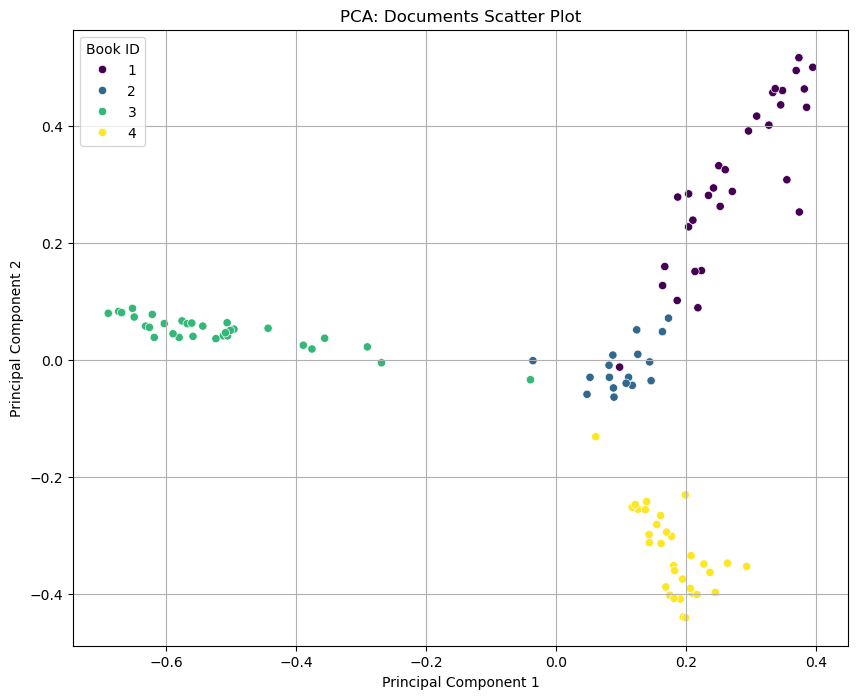

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

pc1 = DCM_TFIDF_L2.iloc[:, 0]
pc2 = DCM_TFIDF_L2.iloc[:, 1]

metadata = DCM_TFIDF_L2.index.get_level_values('book_id')  # Example: coloring by book_id

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pc1, y=pc2, hue=metadata, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Documents Scatter Plot')
plt.grid()
plt.legend(title='Book ID')
plt.show()


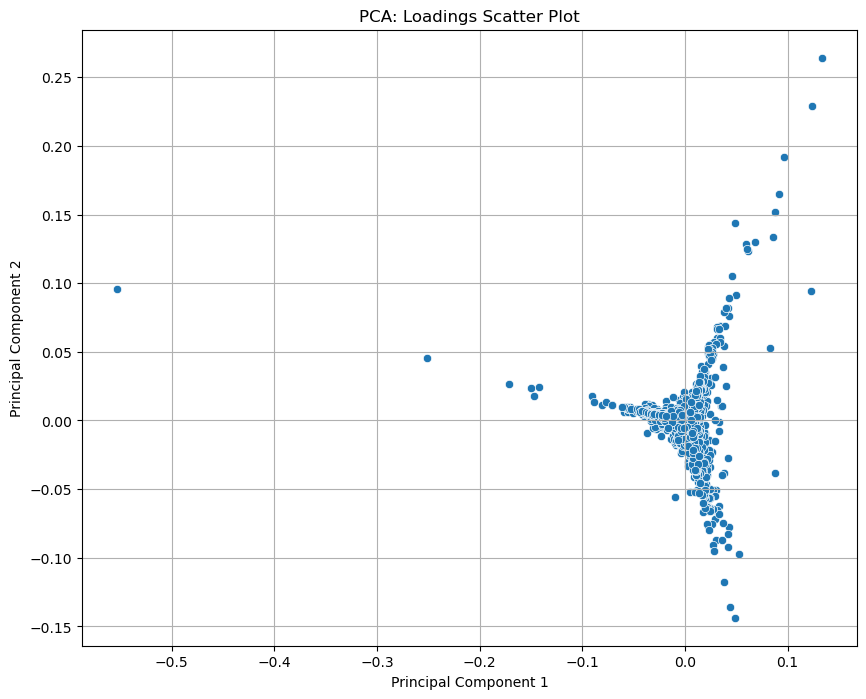

In [196]:

import matplotlib.pyplot as plt
import seaborn as sns

pca_components = LOADINGS_TFIDF_L2.values

# Plot loadings scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Loadings Scatter Plot')
plt.grid()
plt.show()


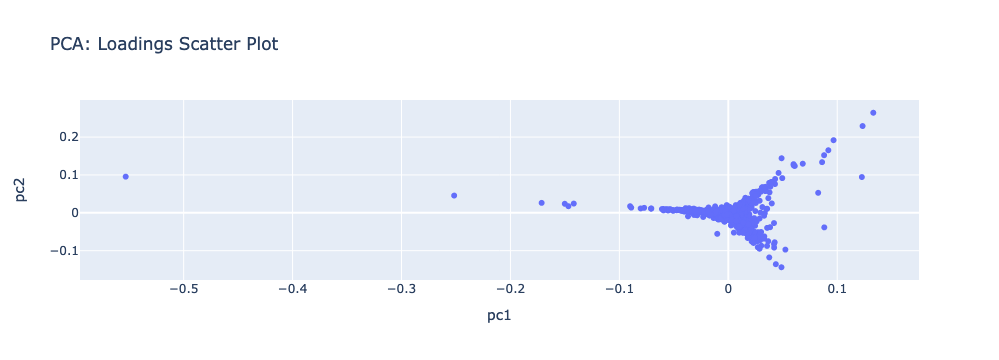

In [198]:
import plotly.express as px
loadings_df = LOADINGS_TFIDF_L2.reset_index()
loadings_df['pc1'] = loadings_df.iloc[:, 1]
loadings_df['pc2'] = loadings_df.iloc[:, 2]

# Create interactive scatter plot for loadings using Plotly
fig = px.scatter(loadings_df, x='pc1', y='pc2',
                 hover_data={'term_str': True},  # Adjust based on the columns available
                 title='PCA: Loadings Scatter Plot')
fig.show()


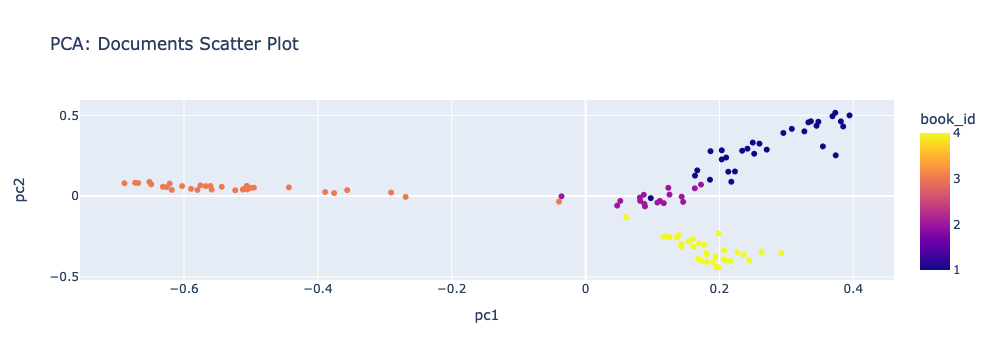

In [200]:
import plotly.express as px
import pandas as pd

# Extract principal component scores and metadata
pc1 = DCM_TFIDF_L2.iloc[:, 0]
pc2 = DCM_TFIDF_L2.iloc[:, 1]
metadata = DCM_TFIDF_L2.index.get_level_values('book_id')  # Adjust based on your actual metadata

# Create DataFrame for plotly
df_plot = DCM_TFIDF_L2.reset_index()
df_plot['pc1'] = pc1.values
df_plot['pc2'] = pc2.values

# Create interactive scatter plot using Plotly
fig = px.scatter(df_plot, x='pc1', y='pc2', color='book_id',
                 hover_data=['chap_num'],  # Add more hover info if needed
                 title='PCA: Documents Scatter Plot')
fig.show()


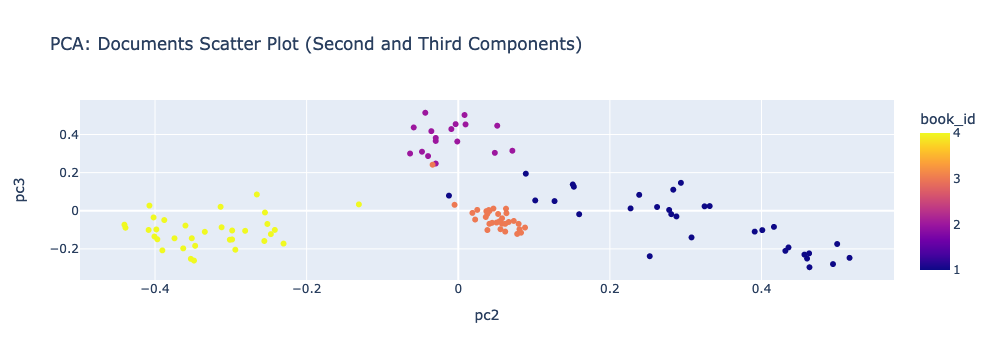

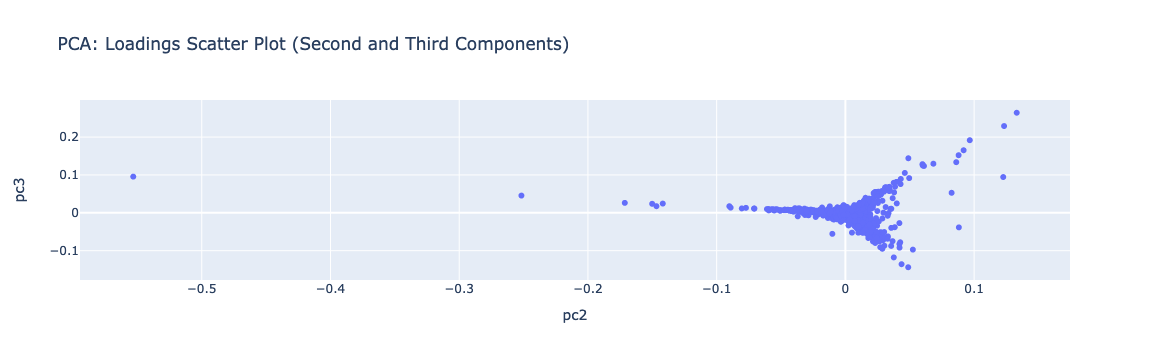

In [201]:
import plotly.express as px

# Create DataFrame for plotly using the second and third principal components
df_plot = DCM_TFIDF_L2.reset_index()
df_plot['pc2'] = DCM_TFIDF_L2.iloc[:, 1].values  # Second component
df_plot['pc3'] = DCM_TFIDF_L2.iloc[:, 2].values  # Third component

# Plot the documents
fig1 = px.scatter(df_plot, x='pc2', y='pc3', color='book_id',
                 hover_data=['chap_num'],  # Add more hover info if needed
                 title='PCA: Documents Scatter Plot (Second and Third Components)')
fig1.show()

# Create DataFrame for the loadings using the second and third principal components
loadings_df = LOADINGS_TFIDF_L2.reset_index()
loadings_df['pc2'] = loadings_df.iloc[:, 1].values  # Second component
loadings_df['pc3'] = loadings_df.iloc[:, 2].values  # Third component

# Plot the loadings
fig2 = px.scatter(loadings_df, x='pc2', y='pc3',
                 hover_data=['term_str'],  # Adjust based on the columns available
                 title='PCA: Loadings Scatter Plot (Second and Third Components)')
fig2.show()


## LDA

In [206]:
from gensim import corpora, models

In [243]:
import pandas as pd # Put here again in case we copy into a separate file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
#import plotly_express as px

class TopicExplorer:
    
    n_features = 4000
    stopwords = 'english'
    lda_num_topics = 20
    lda_max_iter = 20
    lda_n_top_terms = 7
    
    def __init__(self, tokens_df, lib_df, bag, labels=[]):
        self.TOKENS = tokens_df
        self.LIB = lib_df
        self.bag = bag
        self.labels = labels
        
    def generate_tables(self):
        print("BAG:", self.bag[-1])
        print("LABELS:", self.labels)
        print("Getting DOCS")
        self._get_docs()
        print("Getting TERMS")
        self._get_count_model()
        print("Getting THETA, PHI")
        self._get_topic_model()
        print("Getting TOPICS")
        self._get_topics()
        print('Binding LIB labels to THETA')
        self._bind_labels()
        print("Done.")
        return self
        
    def _get_docs(self, pos_remove_pat=r'^NNS?$'):
        self.DOCS = self.TOKENS[self.TOKENS.pos.str.match(pos_remove_pat)]\
            .groupby(self.bag).term_str\
            .apply(lambda x: ' '.join(x))\
            .to_frame()\
            .rename(columns={'term_str':'doc_str'})
        
    def _get_count_model(self):
        self.count_engine = CountVectorizer(max_features=self.n_features, 
                                            stop_words=self.stopwords)
        self.count_model = self.count_engine.fit_transform(self.DOCS.doc_str)
        self.TERMS = self.count_engine.get_feature_names_out()
        
    def _get_topic_model(self):
        self.lda_engine = LDA(n_components=self.lda_num_topics, 
                              max_iter=self.lda_max_iter, 
                              learning_offset=50., 
                              random_state=0)
        self.THETA = pd.DataFrame(self.lda_engine.fit_transform(self.count_model), 
                                  index=self.DOCS.index)
        self.THETA.columns.name = 'topic_id'
        self.PHI = pd.DataFrame(self.lda_engine.components_, columns=self.TERMS)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
    def _get_topics(self, n_terms=10):
        self.TOPICS = self.PHI.stack().to_frame('weight')\
            .groupby('topic_id')\
            .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(self.lda_n_top_terms)\
               .reset_index()\
               .drop('topic_id', axis=1)\
               .term_str)
        self.TOPICS['label'] = self.TOPICS[[t for t in range(self.lda_n_top_terms)]]\
            .apply(lambda x: str(x.name)\
                   .zfill(len(str(self.lda_num_topics))) + ' ' + ' '.join(x), axis=1)
        self.TOPICS['doc_weight_sum'] = self.THETA.sum()
        self.topic_cols = [t for t in range(self.lda_num_topics)]
        
    def _bind_labels(self):
        self.LABELS = {}
        self.LABEL_VALUES = {}
        for label in self.labels:
            self.THETA[label] = self.THETA\
                .apply(lambda x: self.LIB.loc[x.name[0], label], axis=1)
            self.LABELS[label] = self.THETA.groupby(label)[self.topic_cols].mean().T  
            self.THETA = self.THETA.drop(label, axis=1) # Don't keep the column
            self.LABELS[label].index.name = 'topic_id'
            self.LABELS[label]['label'] = self.TOPICS['label']
            self.LABEL_VALUES[label] = sorted(list(set(self.LIB[label])))
            
    def show_dominant_label_topic(self, label):
        X = self.LABELS[label][self.LABEL_VALUES[label]].idxmax()
        return X.to_frame('topic_id').topic_id.map(self.TOPICS.label)
            
    def show_label_values(self):
        for label in self.LABEL_VALUES:
            print(label, ": ", self.LABEL_VALUES[label])
        
    def show_topic_bar(self):
        fig_height = self.lda_num_topics / 3
        self.TOPICS.sort_values('doc_weight_sum', ascending=True)\
            .plot.barh(y='doc_weight_sum', x='label', figsize=(5, fig_height));
        
    def show_topic_label_heatmap(self, label):
        return MP.LABELS[label][MP.LABEL_VALUES[label]].style.background_gradient()
        
    def show_label_comparison_plot(self, label, label_value_x, label_value_y):
        px.scatter(self.LABELS[label].reset_index(), label_value_x, label_value_y, 
                   hover_name='label', text='topic_id', width=800, height=600)\
            .update_traces(mode='text').show()        


BAG: para_num
LABELS: ['author', 'year_of_publish']
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.
T00: project, gutenbergâ, works, work, terms - 00 project gutenbergâ works work terms states foundation
T01: jurgis, man, time, men, day - 01 jurgis man time men day place work
T02: silver, value, quantity, gold, money - 02 silver value quantity gold money goods mines
T03: capitalist, production, economy, sismondi, theory - 03 capitalist production economy sismondi theory problem capitalism
T04: goods, duties, home, country, exportation - 04 goods duties home country exportation trade importation
author
Adam Smith          15 stock profit labour price wages trade capital
Peter Kropotkin          17 work day men society hours man agreement
Rosa Luxemburg     12 capital production value surplus reproducti...
Upton Sinclair                 01 jurgis man time men day place work
Name: topic_id, dtype: object


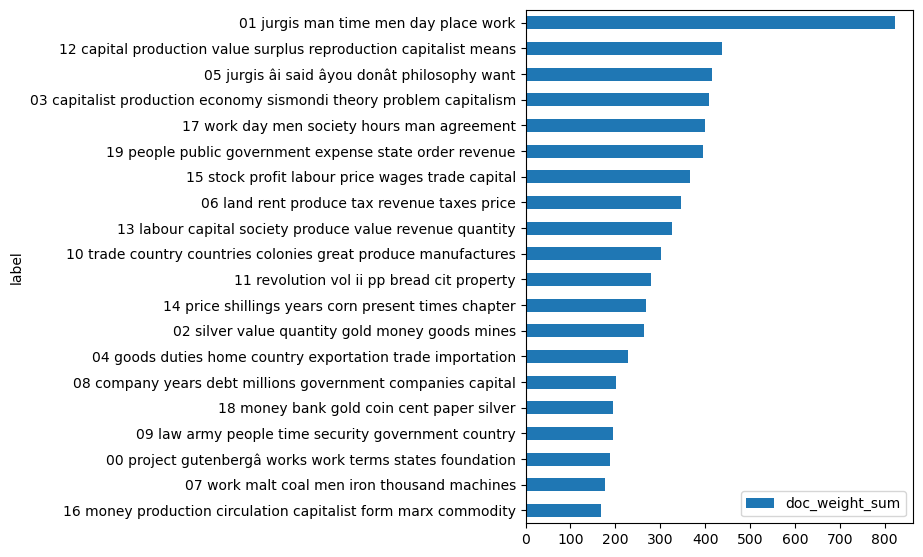

In [244]:

bag = ['book_id', 'chap_num', 'para_num']  # Adjust based on your data structure

explorer = TopicExplorer(tokens_df=CORPUS, lib_df=LIB, bag=bag, labels=['author', 'year_of_publish'])

explorer.generate_tables()

topics = explorer.TOPICS.head(5)
for i, topic in enumerate(topics.iterrows()):
    words = topic[1][:5].tolist()  # Top 5 words
    label = topic[1]['label']  # Topic label
    print(f"T{i:02}: {', '.join(words)} - {label}")

explorer.show_topic_bar()

dominant_topics = explorer.show_dominant_label_topic('author')
print(dominant_topics)


In [265]:
# Extract the first 5 topics
top_topics = explorer.TOPICS.head(5)

topic_info = {}

#  top 5 topics 
for i, topic in enumerate(top_topics.iterrows()):
    # Get the top 5 words for this topic
    top_words = topic[1][:5].tolist()
    topic_info[f"T{i:02}"] = ', '.join(top_words)

for topic, info in topic_info.items():
    print(f"{topic}: {info}")
    
top_5_topics = explorer.TOPICS.sort_values(by='doc_weight_sum', ascending=False).head(5)

print(top_5_topics)


T00: project, gutenbergâ, works, work, terms
T01: jurgis, man, time, men, day
T02: silver, value, quantity, gold, money
T03: capitalist, production, economy, sismondi, theory
T04: goods, duties, home, country, exportation
term_str           0           1        2         3             4           5  \
topic_id                                                                        
1             jurgis         man     time       men           day       place   
12           capital  production    value   surplus  reproduction  capitalist   
5             jurgis          âi     said      âyou         donât  philosophy   
3         capitalist  production  economy  sismondi        theory     problem   
17              work         day      men   society         hours         man   

term_str           6                                              label  \
topic_id                                                                  
1               work              01 jurgis man time men day

In [249]:
# Assuming explorer.TOPICS is your DataFrame
toptops = explorer.TOPICS.sort_values(by='doc_weight_sum', ascending=False)

toptops['label']


topic_id
1                 01 jurgis man time men day place work
12    12 capital production value surplus reproducti...
5          05 jurgis âi said âyou donât philosophy want
3     03 capitalist production economy sismondi theo...
17          17 work day men society hours man agreement
19    19 people public government expense state orde...
15     15 stock profit labour price wages trade capital
6          06 land rent produce tax revenue taxes price
13    13 labour capital society produce value revenu...
10    10 trade country countries colonies great prod...
11           11 revolution vol ii pp bread cit property
14    14 price shillings years corn present times ch...
2       02 silver value quantity gold money goods mines
4     04 goods duties home country exportation trade...
8     08 company years debt millions government comp...
18            18 money bank gold coin cent paper silver
9     09 law army people time security government co...
0     00 project gutenbergâ works work 

In [258]:
topic_explorer = TopicExplorer(CORPUS, LIB, bag=['chap_num','para_num'], labels=[])

# LDA THETA and PHI
topic_explorer.generate_tables()

lda_theta = topic_explorer.THETA
lda_phi = topic_explorer.PHI


BAG: para_num
LABELS: []
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [268]:
# Assuming lda_theta and lda_phi are your DataFrames

# Saving lda_theta as CSV
lda_theta.to_csv('lda_theta.csv', index=False)

# Saving lda_phi as CSV
lda_phi.to_csv('lda_phi.csv', index=False)


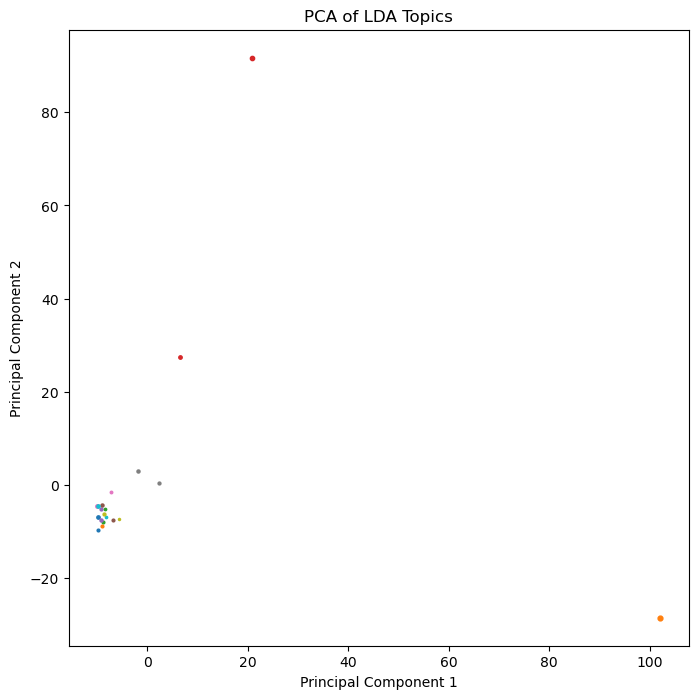

In [262]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

scaler = StandardScaler()
phi_scaled = scaler.fit_transform(topic_explorer.PHI)

pca = PCA(n_components=2)
phi_pca = pca.fit_transform(phi_scaled)

mean_doc_weight = topic_explorer.THETA.mean()

plt.figure(figsize=(8, 8))
for i, topic in enumerate(topic_explorer.PHI.index):
    x, y = phi_pca[i]
    plt.scatter(x, y, s=mean_doc_weight[topic] * 100, label=f'Topic {i}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of LDA Topics')
plt.show()


In [283]:
def is_not_numeric(term):
    return not term.isnumeric()

VOCAB_non_numeric = VOCAB[VOCAB.index.to_series().apply(is_not_numeric)]

VOCAB_sorted = VOCAB_non_numeric.sort_values(by='dfidf', ascending=False)

VOCAB_sub = VOCAB_sorted.head(10000)

VOCAB_sub

n         p          i max_pos max_pos_group    porter_stem  \
term_str                                                                        
loss            127  0.000162  12.592989      NN            NN           loss   
maintenance     168  0.000214  12.189356      NN            NN        mainten   
machinery       143  0.000182  12.421802      NN            NN      machineri   
constant        279  0.000356  11.457552      JJ            JJ       constant   
sight            71  0.000090  13.431926      NN            NN          sight   
...             ...       ...        ...     ...           ...            ...   
vexation         10  0.000013  16.259745      NN            NN          vexat   
constantinople    4  0.000005  17.581673      NN            NN  constantinopl   
indolence         4  0.000005  17.581673      NN            NN          indol   
vexatious         3  0.000004  17.996711      JJ            JJ         vexati   
via               4  0.000005  17.581673      IN            IN            via   

                stop     dfidf  
term_str                        
loss               0  59.44192  
maintenance        0  59.44192  
machinery          0  59.44192  
constant           0  59.44192  
sight              0  59.44192  
...              ...       ...  
vexation           0  11.61471  
constantinople     0  11.61471  
indolence          0  11.61471  
vexatious          0  11.61471  
via                0  11.61471  

[10000 rows x 8 columns]

In [278]:
salex = pd.read_csv('salex_nrc.csv')

In [284]:
VOCAB_sub = pd.merge(VOCAB_sub, salex, on='term_str', how='left')
VOCAB_sub

term_str    n         p          i max_pos max_pos_group  \
0               loss  127  0.000162  12.592989      NN            NN   
1        maintenance  168  0.000214  12.189356      NN            NN   
2          machinery  143  0.000182  12.421802      NN            NN   
3           constant  279  0.000356  11.457552      JJ            JJ   
4              sight   71  0.000090  13.431926      NN            NN   
...              ...  ...       ...        ...     ...           ...   
9995        vexation   10  0.000013  16.259745      NN            NN   
9996  constantinople    4  0.000005  17.581673      NN            NN   
9997       indolence    4  0.000005  17.581673      NN            NN   
9998       vexatious    3  0.000004  17.996711      JJ            JJ   
9999             via    4  0.000005  17.581673      IN            IN   

        porter_stem  stop     dfidf  nrc_anger  nrc_anticipation  nrc_disgust  \
0              loss     0  59.44192        1.0               0.0          0.0   
1           mainten     0  59.44192        NaN               NaN          NaN   
2         machineri     0  59.44192        NaN               NaN          NaN   
3          constant     0  59.44192        0.0               0.0          0.0   
4             sight     0  59.44192        NaN               NaN          NaN   
...             ...   ...       ...        ...               ...          ...   
9995          vexat     0  11.61471        NaN               NaN          NaN   
9996  constantinopl     0  11.61471        NaN               NaN          NaN   
9997          indol     0  11.61471        NaN               NaN          NaN   
9998         vexati     0  11.61471        NaN               NaN          NaN   
9999            via     0  11.61471        NaN               NaN          NaN   

      nrc_fear  nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
0          1.0      0.0           1.0           0.0          1.0   
1          NaN      NaN           NaN           NaN          NaN   
2          NaN      NaN           NaN           NaN          NaN   
3          0.0      0.0           0.0           1.0          0.0   
4          NaN      NaN           NaN           NaN          NaN   
...        ...      ...           ...           ...          ...   
9995       NaN      NaN           NaN           NaN          NaN   
9996       NaN      NaN           NaN           NaN          NaN   
9997       NaN      NaN           NaN           NaN          NaN   
9998       NaN      NaN           NaN           NaN          NaN   
9999       NaN      NaN           NaN           NaN          NaN   

      nrc_surprise  nrc_trust  nrc_sentiment  
0              0.0        0.0           -1.0  
1              NaN        NaN            NaN  
2              NaN        NaN            NaN  
3              0.0        1.0            1.0  
4              NaN        NaN            NaN  
...            ...        ...            ...  
9995           NaN        NaN            NaN  
9996           NaN        NaN            NaN  
9997           NaN        NaN            NaN  
9998           NaN        NaN            NaN  
9999           NaN        NaN            NaN  

[10000 rows x 20 columns]

In [286]:
# Assuming VOCAB_sub is already defined as a DataFrame
VOCAB_sub_clean = VOCAB_sub.dropna()
VOCAB_SENT = VOCAB_sub_clean

# Display the cleaned DataFrame
VOCAB_SENT


term_str    n         p          i max_pos max_pos_group porter_stem  \
0           loss  127  0.000162  12.592989      NN            NN        loss   
3       constant  279  0.000356  11.457552      JJ            JJ    constant   
6     revolution  205  0.000261  11.902193      NN            NN     revolut   
15          iron   83  0.000106  13.206634      NN            NN        iron   
22       respect  140  0.000178  12.452390      NN            NN     respect   
...          ...  ...       ...        ...     ...           ...         ...   
9935   venerable    2  0.000003  18.581673      JJ            JJ       vener   
9942        sing    2  0.000003  18.581673     VBG            VB        sing   
9948    delivery    2  0.000003  18.581673      NN            NN    deliveri   
9965      versus    2  0.000003  18.581673      NN            NN       versu   
9971        monk    2  0.000003  18.581673      NN            NN        monk   

      stop     dfidf  nrc_anger  nrc_anticipation  nrc_disgust  nrc_fear  \
0        0  59.44192        1.0               0.0          0.0       1.0   
3        0  59.44192        0.0               0.0          0.0       0.0   
6        0  59.44192        1.0               1.0          0.0       1.0   
15       0  59.44192        0.0               0.0          0.0       0.0   
22       0  59.44192        0.0               1.0          0.0       0.0   
...    ...       ...        ...               ...          ...       ...   
9935     0  11.61471        0.0               1.0          0.0       0.0   
9942     0  11.61471        0.0               1.0          0.0       0.0   
9948     0  11.61471        0.0               1.0          0.0       0.0   
9965     0  11.61471        1.0               0.0          0.0       0.0   
9971     0  11.61471        0.0               0.0          0.0       0.0   

      nrc_joy  nrc_negative  nrc_positive  nrc_sadness  nrc_surprise  \
0         0.0           1.0           0.0          1.0           0.0   
3         0.0           0.0           1.0          0.0           0.0   
6         0.0           1.0           1.0          1.0           1.0   
15        0.0           0.0           1.0          0.0           0.0   
22        1.0           0.0           1.0          0.0           0.0   
...       ...           ...           ...          ...           ...   
9935      1.0           0.0           1.0          0.0           0.0   
9942      1.0           0.0           1.0          1.0           0.0   
9948      0.0           0.0           1.0          0.0           0.0   
9965      0.0           1.0           0.0          0.0           0.0   
9971      0.0           0.0           1.0          0.0           0.0   

      nrc_trust  nrc_sentiment  
0           0.0           -1.0  
3           1.0            1.0  
6           0.0            0.0  
15          1.0            1.0  
22          1.0            1.0  
...         ...            ...  
9935        1.0            1.0  
9942        1.0            1.0  
9948        0.0            1.0  
9965        0.0           -1.0  
9971        1.0            1.0  

[1389 rows x 20 columns]

In [289]:
VOCAB_SENT.columns

Index(['term_str', 'n', 'p', 'i', 'max_pos', 'max_pos_group', 'porter_stem',
       'stop', 'dfidf', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
       'nrc_fear', 'nrc_joy', 'nrc_negative', 'nrc_positive', 'nrc_sadness',
       'nrc_surprise', 'nrc_trust', 'nrc_sentiment'],
      dtype='object')

In [298]:
# Reset the index of BOW to make term_str a column
BOW_reset = BOW.reset_index()

# Check the data type of term_str columns
print("BOW term_str dtype:", BOW_reset['term_str'].dtype)
print("VOCAB_SENT term_str dtype:", VOCAB_SENT['term_str'].dtype)

# Convert BOW term_str to string if it's not already
if BOW_reset['term_str'].dtype != 'object':
    BOW_reset['term_str'] = BOW_reset['term_str'].astype(str)

# Convert VOCAB_SENT term_str to string if it's not already
if VOCAB_SENT['term_str'].dtype != 'object':
    VOCAB_SENT['term_str'] = VOCAB_SENT['term_str'].astype(str)

# Merge the DataFrames on the term_str column
BOW_SENT = BOW_reset.merge(VOCAB_SENT, on='term_str', how='left')

# Set index back to term_str if needed
BOW_SENT.set_index('term_str', inplace=True)


BOW term_str dtype: object
VOCAB_SENT term_str dtype: object


In [299]:
BOW_SENT

book_id  chap_num  n_x     tfidf  n_y   p   i max_pos  \
term_str                                                              
                    1       1.0   13  0.027420  NaN NaN NaN     NaN   
000                 1       1.0    2  0.006276  NaN NaN NaN     NaN   
100                 1       1.0    1  0.005227  NaN NaN NaN     NaN   
10s                 1       1.0    1  0.008658  NaN NaN NaN     NaN   
10vâ                1       1.0    1  0.014735  NaN NaN NaN     NaN   
...               ...       ...  ...       ...  ...  ..  ..     ...   
âinformation        4      33.0    1  0.002841  NaN NaN NaN     NaN   
âplain              4      33.0    2  0.005302  NaN NaN NaN     NaN   
âproject            4      33.0    5  0.014206  NaN NaN NaN     NaN   
âright              4      33.0    1  0.002841  NaN NaN NaN     NaN   
âthe                4      33.0    1  0.001559  NaN NaN NaN     NaN   

             max_pos_group porter_stem  ...  nrc_anticipation  nrc_disgust  \
term_str                                ...                                  
                       NaN         NaN  ...               NaN          NaN   
000                    NaN         NaN  ...               NaN          NaN   
100                    NaN         NaN  ...               NaN          NaN   
10s                    NaN         NaN  ...               NaN          NaN   
10vâ                   NaN         NaN  ...               NaN          NaN   
...                    ...         ...  ...               ...          ...   
âinformation           NaN         NaN  ...               NaN          NaN   
âplain                 NaN         NaN  ...               NaN          NaN   
âproject               NaN         NaN  ...               NaN          NaN   
âright                 NaN         NaN  ...               NaN          NaN   
âthe                   NaN         NaN  ...               NaN          NaN   

              nrc_fear  nrc_joy  nrc_negative  nrc_positive  nrc_sadness  \
term_str                                                                   
                   NaN      NaN           NaN           NaN          NaN   
000                NaN      NaN           NaN           NaN          NaN   
100                NaN      NaN           NaN           NaN          NaN   
10s                NaN      NaN           NaN           NaN          NaN   
10vâ               NaN      NaN           NaN           NaN          NaN   
...                ...      ...           ...           ...          ...   
âinformation       NaN      NaN           NaN           NaN          NaN   
âplain             NaN      NaN           NaN           NaN          NaN   
âproject           NaN      NaN           NaN           NaN          NaN   
âright             NaN      NaN           NaN           NaN          NaN   
âthe               NaN      NaN           NaN           NaN          NaN   

              nrc_surprise  nrc_trust  nrc_sentiment  
term_str                                              
                       NaN        NaN            NaN  
000                    NaN        NaN            NaN  
100                    NaN        NaN            NaN  
10s                    NaN        NaN            NaN  
10vâ                   NaN        NaN            NaN  
...                    ...        ...            ...  
âinformation           NaN        NaN            NaN  
âplain                 NaN        NaN            NaN  
âproject               NaN        NaN            NaN  
âright                 NaN        NaN            NaN  
âthe                   NaN        NaN            NaN  

[150734 rows x 23 columns]

In [300]:
BOW_SENT_clean = BOW_SENT.dropna()
BOW_SENT_clean

book_id  chap_num  n_x     tfidf    n_y         p          i  \
term_str                                                                     
achieve             1       1.0    1  0.007247   11.0  0.000014  16.122242   
advance             1       1.0    1  0.003459   76.0  0.000097  13.333746   
anarchy             1       1.0    1  0.006975   17.0  0.000022  15.494210   
antagonistic        1       1.0    1  0.011304    4.0  0.000005  17.581673   
assured             1       1.0    1  0.004810   40.0  0.000051  14.259745   
...               ...       ...  ...       ...    ...       ...        ...   
weary               4      33.0    1  0.002150   11.0  0.000014  16.122242   
weight              4      33.0    7  0.009714  136.0  0.000173  12.494210   
white               4      33.0    2  0.001935   81.0  0.000103  13.241823   
word                4      33.0    1  0.000622  100.0  0.000127  12.937817   
worse               4      33.0    3  0.002833   61.0  0.000078  13.650936   

             max_pos max_pos_group porter_stem  ...  nrc_anticipation  \
term_str                                        ...                     
achieve           NN            NN      achiev  ...               0.0   
advance           NN            NN      advanc  ...               1.0   
anarchy           NN            NN     anarchi  ...               0.0   
antagonistic      JJ            JJ  antagonist  ...               0.0   
assured          VBN            VB       assur  ...               0.0   
...              ...           ...         ...  ...               ...   
weary             JJ            JJ       weari  ...               0.0   
weight            NN            NN      weight  ...               1.0   
white             JJ            JJ       white  ...               1.0   
word              NN            NN        word  ...               0.0   
worse            JJR            JJ        wors  ...               0.0   

              nrc_disgust  nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
term_str                                                                   
achieve               0.0       0.0      1.0           0.0           1.0   
advance               0.0       1.0      1.0           0.0           1.0   
anarchy               0.0       1.0      0.0           1.0           0.0   
antagonistic          1.0       0.0      0.0           1.0           0.0   
assured               0.0       0.0      0.0           0.0           1.0   
...                   ...       ...      ...           ...           ...   
weary                 0.0       0.0      0.0           1.0           0.0   
weight                1.0       1.0      1.0           1.0           1.0   
white                 0.0       0.0      1.0           0.0           1.0   
word                  0.0       0.0      0.0           0.0           1.0   
worse                 0.0       1.0      0.0           1.0           0.0   

              nrc_sadness  nrc_surprise  nrc_trust  nrc_sentiment  
term_str                                                           
achieve               0.0           0.0        1.0            1.0  
advance               0.0           1.0        0.0            1.0  
anarchy               0.0           0.0        0.0           -1.0  
antagonistic          0.0           0.0        0.0           -1.0  
assured               0.0           0.0        1.0            1.0  
...                   ...           ...        ...            ...  
weary                 1.0           0.0        0.0           -1.0  
weight                1.0           1.0        1.0            0.0  
white                 0.0           0.0        1.0            1.0  
word                  0.0           0.0        1.0            1.0  
worse                 1.0           0.0        0.0           -1.0  

[15781 rows x 23 columns]

In [301]:
BOW_SENT = BOW_SENT_clean
BOW_SENT

book_id  chap_num  n_x     tfidf    n_y         p          i  \
term_str                                                                     
achieve             1       1.0    1  0.007247   11.0  0.000014  16.122242   
advance             1       1.0    1  0.003459   76.0  0.000097  13.333746   
anarchy             1       1.0    1  0.006975   17.0  0.000022  15.494210   
antagonistic        1       1.0    1  0.011304    4.0  0.000005  17.581673   
assured             1       1.0    1  0.004810   40.0  0.000051  14.259745   
...               ...       ...  ...       ...    ...       ...        ...   
weary               4      33.0    1  0.002150   11.0  0.000014  16.122242   
weight              4      33.0    7  0.009714  136.0  0.000173  12.494210   
white               4      33.0    2  0.001935   81.0  0.000103  13.241823   
word                4      33.0    1  0.000622  100.0  0.000127  12.937817   
worse               4      33.0    3  0.002833   61.0  0.000078  13.650936   

             max_pos max_pos_group porter_stem  ...  nrc_anticipation  \
term_str                                        ...                     
achieve           NN            NN      achiev  ...               0.0   
advance           NN            NN      advanc  ...               1.0   
anarchy           NN            NN     anarchi  ...               0.0   
antagonistic      JJ            JJ  antagonist  ...               0.0   
assured          VBN            VB       assur  ...               0.0   
...              ...           ...         ...  ...               ...   
weary             JJ            JJ       weari  ...               0.0   
weight            NN            NN      weight  ...               1.0   
white             JJ            JJ       white  ...               1.0   
word              NN            NN        word  ...               0.0   
worse            JJR            JJ        wors  ...               0.0   

              nrc_disgust  nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
term_str                                                                   
achieve               0.0       0.0      1.0           0.0           1.0   
advance               0.0       1.0      1.0           0.0           1.0   
anarchy               0.0       1.0      0.0           1.0           0.0   
antagonistic          1.0       0.0      0.0           1.0           0.0   
assured               0.0       0.0      0.0           0.0           1.0   
...                   ...       ...      ...           ...           ...   
weary                 0.0       0.0      0.0           1.0           0.0   
weight                1.0       1.0      1.0           1.0           1.0   
white                 0.0       0.0      1.0           0.0           1.0   
word                  0.0       0.0      0.0           0.0           1.0   
worse                 0.0       1.0      0.0           1.0           0.0   

              nrc_sadness  nrc_surprise  nrc_trust  nrc_sentiment  
term_str                                                           
achieve               0.0           0.0        1.0            1.0  
advance               0.0           1.0        0.0            1.0  
anarchy               0.0           0.0        0.0           -1.0  
antagonistic          0.0           0.0        0.0           -1.0  
assured               0.0           0.0        1.0            1.0  
...                   ...           ...        ...            ...  
weary                 1.0           0.0        0.0           -1.0  
weight                1.0           1.0        1.0            0.0  
white                 0.0           0.0        1.0            1.0  
word                  0.0           0.0        1.0            1.0  
worse                 1.0           0.0        0.0           -1.0  

[15781 rows x 23 columns]

In [324]:
import gensim

BAG = OHCO[:1] # BOOKS
DOCS = CORPUS.groupby(BAG)


def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument([str(w) for w in list_of_words], [i])
data = DOCS.term_str.apply(lambda x: list(x)).to_list()
data_for_training = list(tagged_document(data))
#data_for_training[5][1]

data = DOCS.term_str.apply(lambda x: list(x)).to_list()
data_for_training = list(tagged_document(data))
data_for_training
#data_for_training[5][1]
model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)
LIB
DOC_SENT = pd.DataFrame( model.dv.get_normed_vectors(), index=LIB.title)
DOC_SENT

0         1         2         3         4   \
title                                                                           
The Accumulation of Capital -0.229366 -0.067978 -0.141477  0.233117 -0.002030   
The Conquest of Bread       -0.273768 -0.287635 -0.021265 -0.006667  0.170889   
The Jungle                  -0.038347 -0.076400 -0.297752  0.180091  0.285815   
The Wealth of Nations        0.062647  0.066080 -0.390366  0.364735  0.019661   

                                   5         6         7         8         9   \
title                                                                           
The Accumulation of Capital  0.082878 -0.125302 -0.033135 -0.348856  0.221239   
The Conquest of Bread       -0.076847 -0.135759  0.027600 -0.205050 -0.003381   
The Jungle                   0.018763 -0.069688 -0.110274 -0.029209  0.183641   
The Wealth of Nations        0.022124 -0.223567 -0.075722 -0.072240  0.006499   

                             ...        30        31        32        33  \
title                        ...                                           
The Accumulation of Capital  ...  0.357256  0.079567  0.001578  0.175545   
The Conquest of Bread        ...  0.114135  0.068004 -0.262851 -0.138387   
The Jungle                   ...  0.236368 -0.089586 -0.233166 -0.139241   
The Wealth of Nations        ...  0.182373  0.167143 -0.014554 -0.291307   

                                   34        35        36        37        38  \
title                                                                           
The Accumulation of Capital  0.122898 -0.063281  0.175928 -0.027137 -0.038655   
The Conquest of Bread       -0.114051  0.215733  0.126020 -0.341328 -0.043632   
The Jungle                   0.154289 -0.115374 -0.096249 -0.309565  0.077080   
The Wealth of Nations        0.014504  0.097595  0.120051  0.006858 -0.243889   

                                   39  
title                                  
The Accumulation of Capital -0.102167  
The Conquest of Bread       -0.107848  
The Jungle                   0.132545  
The Wealth of Nations       -0.083506  

[4 rows x 40 columns]

In [325]:
# Specify the path where the CSV will be saved
output_csv_path = 'doc_sent.csv'

# Save the DataFrame to a CSV file
DOC_SENT.to_csv(output_csv_path, index=True)  # index=True to save the index as a column

print(f"DataFrame has been saved as {output_csv_path}")


DataFrame has been saved as doc_sent.csv


In [318]:
import gensim
import pandas as pd

# Assuming OHCO is properly defined
BAG = OHCO[:1]  # Adjust OHCO indexing as needed
DOCS = CORPUS.groupby(BAG)

# Tagged document generator
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument([str(w) for w in list_of_words], [i])

# Prepare data
data = DOCS.term_str.apply(lambda x: list(x)).to_list()

# Verify the data has enough elements
if len(data) > 5:
    data_for_training = list(tagged_document(data))
    print(data_for_training[5][1])  # Print index 5 to validate
else:
    print("Insufficient data for accessing index 5")

# Train the model if data is sufficient
if len(data) > 0:
    data_for_training = list(tagged_document(data))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
    model.build_vocab(data_for_training)
    model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

    # Ensure LIB is correctly defined and contains the required column
    if 'unique_identifier' in LIB.columns:
        DOC_SENT = pd.DataFrame(model.dv.get_normed_vectors(), index=LIB['unique_identifier'])
        print(DOC_SENT)
    else:
        print(f"Column 'unique_identifier' not found in LIB. Available columns: {LIB.columns}")
else:
    print("No data available for training.")


Insufficient data for accessing index 5
Column 'unique_identifier' not found in LIB. Available columns: Index(['title', 'author', 'year_of_publish'], dtype='object')


In [326]:
OHCO[:1]

['book_id']

In [331]:
BOW_SENT.head(23)

book_id  chap_num  n_x     tfidf    n_y         p          i  \
term_str                                                                      
achieve              1       1.0    1  0.007247   11.0  0.000014  16.122242   
advance              1       1.0    1  0.003459   76.0  0.000097  13.333746   
anarchy              1       1.0    1  0.006975   17.0  0.000022  15.494210   
antagonistic         1       1.0    1  0.011304    4.0  0.000005  17.581673   
assured              1       1.0    1  0.004810   40.0  0.000051  14.259745   
attack               1       1.0    1  0.006494   21.0  0.000027  15.189356   
calls                1       1.0    1  0.004810   32.0  0.000041  14.581673   
career               1       1.0    2  0.015746   11.0  0.000014  16.122242   
case                 1       1.0    3  0.003510  348.0  0.000444  11.138730   
cash                 1       1.0    1  0.006077   50.0  0.000064  13.937817   
competition          1       1.0    3  0.008542  184.0  0.000235  12.058111   
constant             1       1.0    6  0.018829  279.0  0.000356  11.457552   
continue             1       1.0    1  0.003375  100.0  0.000127  12.937817   
create               1       1.0    3  0.012658   45.0  0.000057  14.089820   
cutting              1       1.0    2  0.015746   11.0  0.000014  16.122242   
deal                 1       1.0    1  0.002278  184.0  0.000235  12.058111   
death                1       1.0    1  0.002918   76.0  0.000097  13.333746   
demand               1       1.0   15  0.027700  447.0  0.000570  10.777542   
dependent            1       1.0    1  0.004943   38.0  0.000048  14.333746   
depression           1       1.0    1  0.007544   13.0  0.000017  15.881233   
despotic             1       1.0    2  0.019417    6.0  0.000008  16.996711   
destroying           1       1.0    1  0.007544   13.0  0.000017  15.881233   
determination        1       1.0    2  0.018279    7.0  0.000009  16.774318   

              max_pos max_pos_group porter_stem  ...  nrc_anticipation  \
term_str                                         ...                     
achieve            NN            NN      achiev  ...               0.0   
advance            NN            NN      advanc  ...               1.0   
anarchy            NN            NN     anarchi  ...               0.0   
antagonistic       JJ            JJ  antagonist  ...               0.0   
assured           VBN            VB       assur  ...               0.0   
attack             NN            NN      attack  ...               0.0   
calls             NNS            NN        call  ...               1.0   
career             NN            NN      career  ...               1.0   
case               NN            NN        case  ...               0.0   
cash               NN            NN        cash  ...               1.0   
competition        NN            NN    competit  ...               1.0   
constant           JJ            JJ    constant  ...               0.0   
continue           NN            NN     continu  ...               1.0   
create             NN            NN       creat  ...               0.0   
cutting           VBG            VB         cut  ...               0.0   
deal               NN            NN        deal  ...               1.0   
death              NN            NN       death  ...               1.0   
demand             NN            NN      demand  ...               0.0   
dependent          NN            NN      depend  ...               0.0   
depression         NN            NN     depress  ...               0.0   
despotic           JJ            JJ      despot  ...               0.0   
destroying        VBG            VB     destroy  ...               0.0   
determination      NN            NN    determin  ...               0.0   

               nrc_disgust  nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
term_str                                                                    
achieve                0.0       0

In [332]:
BOW_SENT.columns

Index(['book_id', 'chap_num', 'n_x', 'tfidf', 'n_y', 'p', 'i', 'max_pos',
       'max_pos_group', 'porter_stem', 'stop', 'dfidf', 'nrc_anger',
       'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'nrc_sentiment'],
      dtype='object')

In [333]:
BOW_SENT

book_id  chap_num  n_x     tfidf    n_y         p          i  \
term_str                                                                     
achieve             1       1.0    1  0.007247   11.0  0.000014  16.122242   
advance             1       1.0    1  0.003459   76.0  0.000097  13.333746   
anarchy             1       1.0    1  0.006975   17.0  0.000022  15.494210   
antagonistic        1       1.0    1  0.011304    4.0  0.000005  17.581673   
assured             1       1.0    1  0.004810   40.0  0.000051  14.259745   
...               ...       ...  ...       ...    ...       ...        ...   
weary               4      33.0    1  0.002150   11.0  0.000014  16.122242   
weight              4      33.0    7  0.009714  136.0  0.000173  12.494210   
white               4      33.0    2  0.001935   81.0  0.000103  13.241823   
word                4      33.0    1  0.000622  100.0  0.000127  12.937817   
worse               4      33.0    3  0.002833   61.0  0.000078  13.650936   

             max_pos max_pos_group porter_stem  ...  nrc_anticipation  \
term_str                                        ...                     
achieve           NN            NN      achiev  ...               0.0   
advance           NN            NN      advanc  ...               1.0   
anarchy           NN            NN     anarchi  ...               0.0   
antagonistic      JJ            JJ  antagonist  ...               0.0   
assured          VBN            VB       assur  ...               0.0   
...              ...           ...         ...  ...               ...   
weary             JJ            JJ       weari  ...               0.0   
weight            NN            NN      weight  ...               1.0   
white             JJ            JJ       white  ...               1.0   
word              NN            NN        word  ...               0.0   
worse            JJR            JJ        wors  ...               0.0   

              nrc_disgust  nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
term_str                                                                   
achieve               0.0       0.0      1.0           0.0           1.0   
advance               0.0       1.0      1.0           0.0           1.0   
anarchy               0.0       1.0      0.0           1.0           0.0   
antagonistic          1.0       0.0      0.0           1.0           0.0   
assured               0.0       0.0      0.0           0.0           1.0   
...                   ...       ...      ...           ...           ...   
weary                 0.0       0.0      0.0           1.0           0.0   
weight                1.0       1.0      1.0           1.0           1.0   
white                 0.0       0.0      1.0           0.0           1.0   
word                  0.0       0.0      0.0           0.0           1.0   
worse                 0.0       1.0      0.0           1.0           0.0   

              nrc_sadness  nrc_surprise  nrc_trust  nrc_sentiment  
term_str                                                           
achieve               0.0           0.0        1.0            1.0  
advance               0.0           1.0        0.0            1.0  
anarchy               0.0           0.0        0.0           -1.0  
antagonistic          0.0           0.0        0.0           -1.0  
assured               0.0           0.0        1.0            1.0  
...                   ...           ...        ...            ...  
weary                 1.0           0.0        0.0           -1.0  
weight                1.0           1.0        1.0            0.0  
white                 0.0           0.0        1.0            1.0  
word                  0.0           0.0        1.0            1.0  
worse                 1.0           0.0        0.0           -1.0  

[15781 rows x 23 columns]

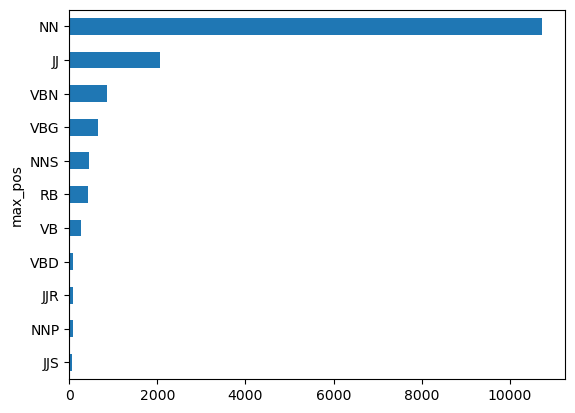

In [334]:
BOW_SENT.max_pos.value_counts().sort_values().plot.barh();

In [335]:
sent = ['nrc_anger',
       'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'nrc_sentiment']

In [337]:
EMO_BOOKS = BOW_SENT.groupby(['book_id'])[sent].mean()

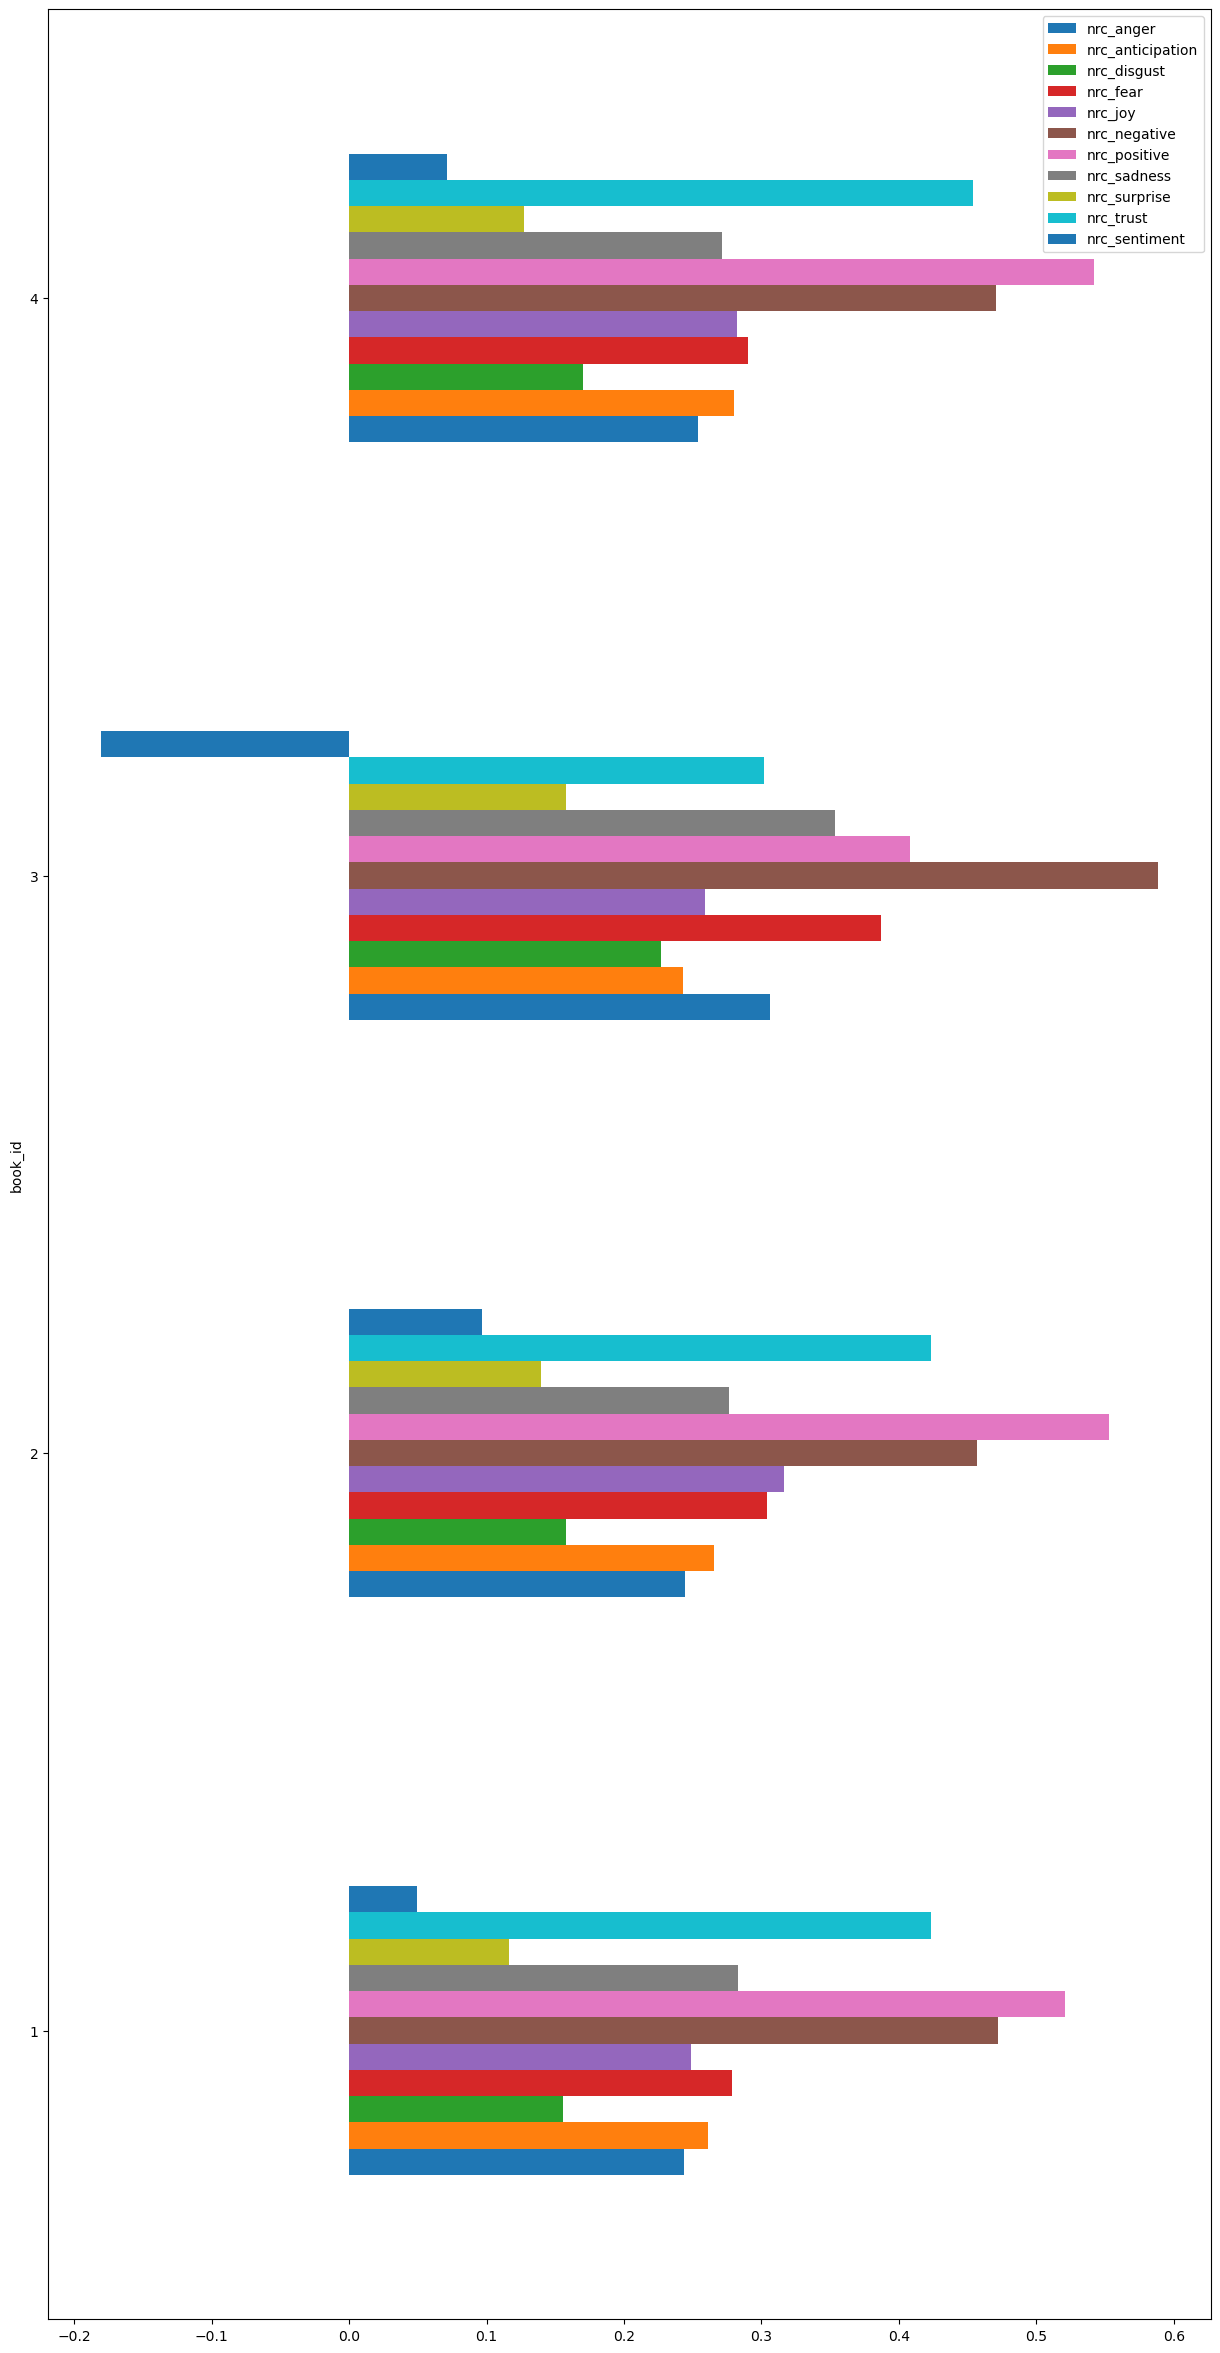

In [338]:
EMO_BOOKS.plot.barh(figsize=(15,30));

In [339]:
# Define paths to save CSVs
LOADINGS_TFIDF_L2_CSV = 'LOADINGS_TFIDF_L2.csv'
DCM_TFIDF_L2_CSV = 'DCM_TFIDF_L2.csv'
COMPINF_TFIDF_L2_CSV = 'COMPINF_TFIDF_L2.csv'
DTM_TFIDF_CSV = 'DTM_TFIDF.csv'

# Save each DataFrame as a CSV file
LOADINGS_TFIDF_L2.to_csv(LOADINGS_TFIDF_L2_CSV, index=True)
DCM_TFIDF_L2.to_csv(DCM_TFIDF_L2_CSV, index=True)
COMPINF_TFIDF_L2.to_csv(COMPINF_TFIDF_L2_CSV, index=True)
DTM_tfidf.to_csv(DTM_TFIDF_CSV, index=True)

print(f"DataFrames have been saved as {LOADINGS_TFIDF_L2_CSV}, {DCM_TFIDF_L2_CSV}, {COMPINF_TFIDF_L2_CSV}, and {DTM_TFIDF_CSV}")


DataFrames have been saved as LOADINGS_TFIDF_L2.csv, DCM_TFIDF_L2.csv, COMPINF_TFIDF_L2.csv, and DTM_TFIDF.csv


## VOCAB_W2V

In [341]:
class W2VExplorer:
    
    w2v_min_count:int = 10
    w2v_workers:int = 4
    w2v_size:int = 256
    w2v_window:int = 2
    tsne_perplexity:int = 40
    tsne_n_components:int = 2
    tsne_init:str = 'pca'
    tsne_n_iter:int = 2500
    tsne_random_state:int = 23
        
    
    def __init__(self, tokens, bag):
        self.TOKENS:pd.DataFrame = tokens
        self.BAG = bag
        
    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self
        
    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """Run word2vec again the docs"""
        self.model = word2vec.Word2Vec(self.DOCS, 
                                 vector_size = self.w2v_size, 
                                 window = self.w2v_window, 
                                 min_count = self.w2v_min_count, 
                                 workers = self.w2v_workers)

    def _get_tsne_coords(self):
        # self.coords = pd.DataFrame(index=range(len(self.model.wv.vocab))) # Gensim 3
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        # self.coords['label'] = [w for w in self.model.wv.vocab] # Gensim 3
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity = 40, 
                               n_components = self.tsne_n_components, 
                               init = self.tsne_init, 
                               n_iter = self.tsne_n_iter, 
                               random_state = self.tsne_random_state)
        # self.tsne_values = self.tsne_model.fit_transform(self.coords['vector'].tolist())
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:,0]
        self.coords['y'] = self.tsne_values[:,1]
        
    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000)\
            .update_traces(mode='text').show()
        
    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim'])        


In [343]:
import pandas as pd

class W2VExplorer:
    w2v_min_count: int = 10
    w2v_workers: int = 4
    w2v_size: int = 256
    w2v_window: int = 2
    tsne_perplexity: int = 40
    tsne_n_components: int = 2
    tsne_init: str = 'pca'
    tsne_n_iter: int = 2500
    tsne_random_state: int = 23

    def __init__(self, tokens, bag):
        self.TOKENS: pd.DataFrame = tokens
        self.BAG = bag

    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self

    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda x: x.tolist())\
            .reset_index()['term_str'].tolist()

    def _get_model(self):
        """Run word2vec against the docs"""
        self.model = word2vec.Word2Vec(self.DOCS,
                                       vector_size=self.w2v_size,
                                       window=self.w2v_window,
                                       min_count=self.w2v_min_count,
                                       workers=self.w2v_workers)

    def _get_tsne_coords(self):
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity=self.tsne_perplexity,
                               n_components=self.tsne_n_components,
                               init=self.tsne_init,
                               n_iter=self.tsne_n_iter,
                               random_state=self.tsne_random_state)
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:, 0]
        self.coords['y'] = self.tsne_values[:, 1]

    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000) \
            .update_traces(mode='text').show()

    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim'])

    def get_vocab_w2v(self, vocab_df):
        vocab_terms = vocab_df['term'].tolist()
        w2v_data = []
        for term in vocab_terms:
            if term in self.model.wv:
                w2v_data.append([term] + self.model.wv.get_vector(term).tolist())
            else:
                w2v_data.append([term] + [None] * self.w2v_size)
        columns = ['term'] + [f'w2v_{i}' for i in range(self.w2v_size)]
        return pd.DataFrame(w2v_data, columns=columns)


In [350]:
# Reset the index to make 'term_str' a column instead of an index
vocab_df = VOCAB.reset_index()

# Extract the tokens without adding the column again
if 'term_str' not in vocab_df.columns:
    tokens = vocab_df[['term_str']]
else:
    tokens = vocab_df

# Choose a meaningful name for grouping, assuming 'term_str' itself
bag = 'term_str'

# Initialize and use the W2VExplorer class with tokens and bag
w2v_explorer = W2VExplorer(tokens=tokens, bag=[bag])
w2v_explorer.generate_model()

# Utilize additional functions from the W2VExplorer class as needed
# For instance:
# vocab_w2v_df = w2v_explorer.get_vocab_w2v(VOCAB)


Bag: term_str
Getting DOCS


ValueError: cannot insert term_str, already exists

In [353]:
tokens

term_str    n         p          i max_pos max_pos_group porter_stem  \
0              0  432  0.000551  10.826786      CD            CD           0   
1            000  410  0.000523  10.902193      CD            CD         000   
2         000397    1  0.000001  19.581673      CD            CD      000397   
3         000412    1  0.000001  19.581673      CD            CD      000412   
4           000c   27  0.000034  14.826786      CD            CD        000c   
...          ...  ...       ...        ...     ...           ...         ...   
25229     ãlites    1  0.000001  19.581673      NN            NN       ãlite   
25230  ãlãgantes    1  0.000001  19.581673      NN            NN     ãlãgant   
25231       ãtat    1  0.000001  19.581673      NN            NN        ãtat   
25232      ãªtre    2  0.000003  18.581673      NN            NN       ãªtre   
25233      ã¼ber    8  0.000010  16.581673      NN            NN       ã¼ber   

       stop      dfidf  
0         0  25.334355  
1         0  59.441920  
2         0   6.807355  
3         0   6.807355  
4         0  25.334355  
...     ...        ...  
25229     0   6.807355  
25230     0   6.807355  
25231     0   6.807355  
25232     0  11.614710  
25233     0  28.000000  

[25234 rows x 9 columns]

In [ ]:
# Assuming VOCAB DataFrame is pre-loaded
# Check if 'term_str' is in the columns
if 'term_str' in VOCAB.index.names:
    tokens = VOCAB.reset_index()[['term_str']]
else:
    tokens = VOCAB[['term_str']]

# Pass the existing 'term_str' as the bag
bag = 'term_str'

# Initialize and use the W2VExplorer class with tokens and bag
w2v_explorer = W2VExplorer(tokens=tokens, bag=[bag])
w2v_explorer.generate_model()


Bag: term_str
Getting DOCS


In [1]:
VOCAB

NameError: name 'VOCAB' is not defined